# 估值分析（PE/PB 分布、行业差异、历史分位数）
本笔记围绕最新截面估值和历史分位数展开，涵盖数据加载、清洗、分布可视化、行业对比、历史分位数计算，以及估值分位与未来收益的初探关联。

## 大纲
3.1 加载依赖与数据读取
3.2 估值指标清洗与过滤规则
3.3 整体 PE/PB 分布可视化
3.4 按行业分组的 PE/PB 分布对比
3.5 历史分位数计算与可视化
3.6 估值分位数与未来收益初探


## 3.1 加载依赖与数据读取
- 读取每日估值（pe_ttm, pb, dv_ratio, turnover_rate, total_mv），行业分类（申万/中信）。
- 设定数据路径、抽样日期（默认为最新交易日），缓存目录。
- 保留最小字段，便于后续合并。

In [13]:
# 参数与数据加载
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 自动向上查找包含 src 目录的项目根目录
def find_project_root(start: Path, marker: str = 'src') -> Path:
    current = start
    for _ in range(5):
        if (current / marker).exists():
            return current
        if current.parent == current:
            break
        current = current.parent
    return start

project_root = find_project_root(Path.cwd())
sys.path.insert(0, str(project_root))

from src.utils.config import get_data_path
from src.utils.io import load_parquet

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style('whitegrid')

# 路径与日期
meta_path = get_data_path('meta')
daily_valuation_dir = get_data_path('raw') / 'market' / 'daily_basic'
industry_file = meta_path / 'stock_basic.parquet'
cache_dir = project_root / 'reports' / 'cache'
cache_dir.mkdir(parents=True, exist_ok=True)

# 读取行业与估值
stock_basic = load_parquet(industry_file)
stock_basic['ts_code_norm'] = stock_basic['ts_code'].str.replace('.', '_', regex=False)
stock_basic['industry'] = stock_basic['industry'].fillna('未知')

# 最新交易日
trade_cal = load_parquet(meta_path / 'trade_cal.parquet')
trade_days = pd.to_datetime(trade_cal[trade_cal['is_open'] == 1]['cal_date'])
latest_trade_date = trade_days.max()
print(f'最新交易日: {latest_trade_date.date()}')

fields_need = ['ts_code','trade_date','pe_ttm','pb','dv_ratio','turnover_rate','total_mv']

def load_latest_snapshot():
    files = sorted(daily_valuation_dir.glob('*.parquet'))
    frames = []
    for f in files:
        df = load_parquet(f)
        if df.empty:
            continue
        df['trade_date'] = pd.to_datetime(df['trade_date'])
        # 优先取指定最新交易日，不存在则退回该文件自身的最新交易日
        df_target = df[df['trade_date'] == latest_trade_date]
        if df_target.empty:
            fallback_date = df['trade_date'].max()
            df_target = df[df['trade_date'] == fallback_date]
        if df_target.empty:
            continue
        # 统一列名，缺失列填 NA，避免因全 NA 列被丢弃导致样本为 0
        df_fields = df_target.reindex(columns=fields_need)
        # pe/pb 都缺失就跳过
        if df_fields[['pe_ttm','pb']].notna().sum().sum() == 0:
            continue
        frames.append(df_fields.assign(ts_code_norm=f.stem))
    # 丢弃全 NA 列，并过滤空 / 全 NA 片段，避免 concat FutureWarning
    clean_frames = []
    for x in frames:
        x = x.dropna(axis=1, how='all')
        if x.shape[0] == 0 or x.shape[1] == 0 or x.isna().all(axis=None):
            continue
        clean_frames.append(x)
    if not clean_frames:
        return pd.DataFrame(columns=fields_need + ['ts_code_norm'])
    snap = pd.concat(clean_frames, ignore_index=True, copy=False)
    return snap

snap = load_latest_snapshot()
print(f'截面样本: {len(snap)}')

最新交易日: 2025-12-26
截面样本: 5424


## 3.2 估值指标清洗与过滤规则
- 过滤异常：PE<=0、PB<=0、缺失值；可选过滤市值下限。
- 极端值处理：对截面 PE/PB 进行分位截尾（默认 1%/99% winsor）。
- 可选：仅保留主板/创业板或行业白名单。

In [14]:
# 估值清洗与截尾
WINSOR_LO = 0.05
WINSOR_HI = 0.95
MV_MIN = None  # 可按需调整市值下限，None 表示不限制
MARKET_WHITELIST = None  # 例如 ['主板','创业板']

snap_clean = snap.copy()
snap_clean = snap_clean.merge(stock_basic[['ts_code','ts_code_norm','industry','market']], on='ts_code_norm', how='left')
snap_clean['market'] = snap_clean['market'].fillna('未知')
snap_clean['industry'] = snap_clean['industry'].fillna('未知')

# 数值化主要字段，便于过滤
for col in ['pe_ttm', 'pb', 'total_mv', 'dv_ratio', 'turnover_rate']:
    if col in snap_clean:
        snap_clean[col] = pd.to_numeric(snap_clean[col], errors='coerce')

# 基础过滤：正的 PE/PB
snap_clean = snap_clean[(snap_clean['pe_ttm'] > 0) & (snap_clean['pb'] > 0)]

# 可选市值过滤
if MV_MIN is not None and 'total_mv' in snap_clean:
    snap_clean = snap_clean[snap_clean['total_mv'] >= MV_MIN]

# 可选市场白名单
if MARKET_WHITELIST:
    snap_clean = snap_clean[snap_clean['market'].isin(MARKET_WHITELIST)]

if snap_clean.empty:
    print('过滤后样本为空，请放宽 MV_MIN 或 MARKET_WHITELIST')
else:
    # Winsor 处理极值
    for col in ['pe_ttm', 'pb']:
        lo, hi = snap_clean[col].quantile([WINSOR_LO, WINSOR_HI])
        snap_clean[col] = snap_clean[col].clip(lower=lo, upper=hi)

    print(snap_clean[['pe_ttm', 'pb']].describe([0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]))
    print(f'清洗后样本量: {len(snap_clean)}')

            pe_ttm           pb
count  3922.000000  3922.000000
mean     83.257925     3.556766
std      96.619432     2.345682
min      12.413500     0.968405
1%       12.413500     0.968405
10%      15.995360     1.220280
25%      24.813525     1.829250
50%      44.551650     2.856000
75%      91.629750     4.509550
90%     223.764930     7.295490
99%     387.526040     9.713045
max     387.526040     9.713045
清洗后样本量: 3922


## 3.3 整体 PE/PB 分布可视化
- 截面直方图 + KDE，叠加阈值线（PE 10/20/40）。
- 展示清洗后的样本分布。

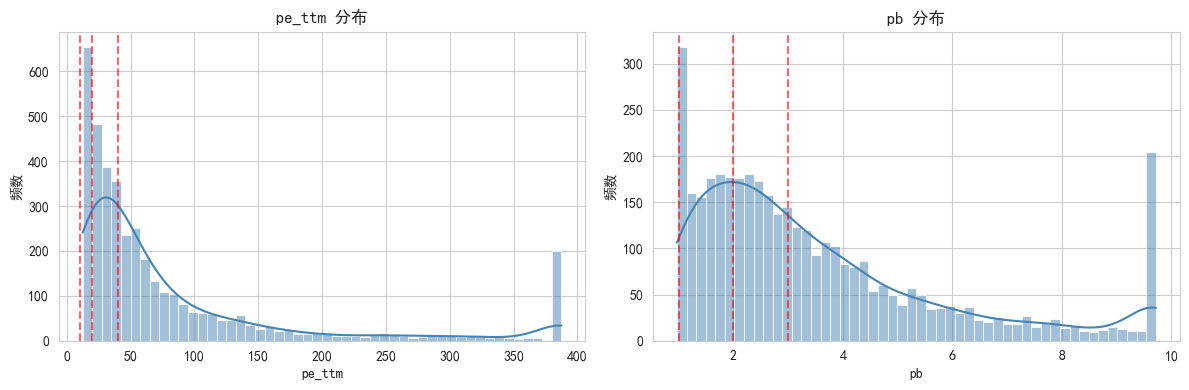

分位数（截面）：
            pe_ttm           pb
count  3922.000000  3922.000000
mean     83.257925     3.556766
std      96.619432     2.345682
min      12.413500     0.968405
10%      15.995360     1.220280
25%      24.813525     1.829250
50%      44.551650     2.856000
75%      91.629750     4.509550
90%     223.764930     7.295490
95%     387.498718     9.712328
99%     387.526040     9.713045
max     387.526040     9.713045


In [15]:
# 截面分布可视化
if snap_clean.empty:
    raise ValueError(f'snap_clean 为空，当前截面样本量={len(snap)}，请检查上游过滤')

# 确保中文字体可用，避免缺字形警告
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, col, lines in zip(axes, ['pe_ttm', 'pb'], [[10, 20, 40], [1, 2, 3]]):
    sns.histplot(snap_clean[col], kde=True, ax=ax, color='steelblue', edgecolor='white', bins=50)
    for l in lines:
        ax.axvline(l, color='red', linestyle='--', alpha=0.6)
    ax.set_title(f'{col} 分布')
    ax.set_xlabel(col)
    ax.set_ylabel('频数')
plt.tight_layout()
plt.show()

print('分位数（截面）：')
print(snap_clean[['pe_ttm','pb']].describe([0.1,0.25,0.5,0.75,0.9,0.95,0.99]))

## 3.4 按行业分组的 PE/PB 分布对比
- 行业箱线/小提琴：对比中位数、IQR、尾部。
- 输出行业分位统计表，方便导出。

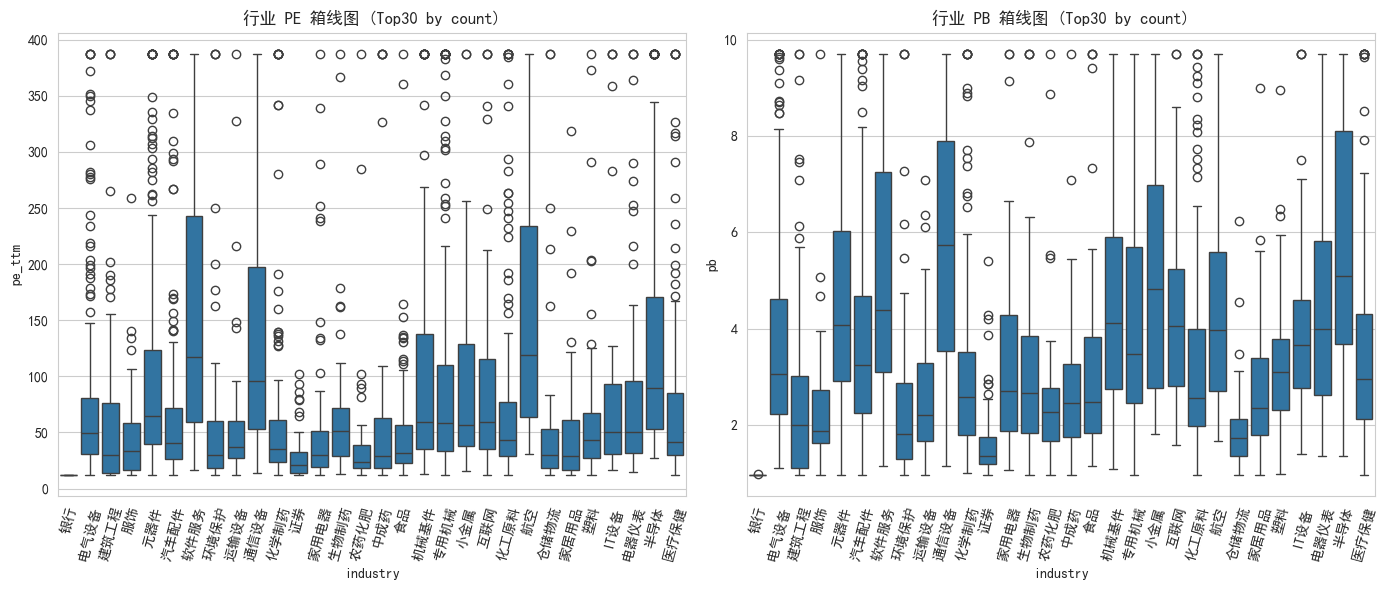

,pe_ttm_median,pe_ttm_mean,pe_ttm_std,pe_ttm_min,pe_ttm_max,pe_ttm_p10,pe_ttm_p90,pb_median,pb_mean,pb_std,pb_min,pb_max,pb_p10,pb_p90
industry,,,,,,,,,,,,,,
保险,12.4135,12.413500,0.000000,12.4135,12.4135,12.4135,12.41350,1.433000,1.693420,0.462918,1.313500,2.2600,1.319900,2.208440
银行,12.4135,12.413500,0.000000,12.4135,12.4135,12.4135,12.41350,0.968405,0.968555,0.000971,0.968405,0.9747,0.968405,0.968405
路桥,13.4548,18.281011,11.970425,12.4135,60.2357,12.4135,30.31880,1.014500,1.252339,0.414322,0.968405,2.3499,0.968405,1.724440
火力发电,13.7053,40.355740,58.500816,12.4135,297.7856,12.4135,102.44126,1.312750,1.754458,1.473038,0.968405,8.6644,0.968405,2.949500
港口,15.9682,21.190619,11.699122,12.4135,51.8089,12.4135,35.67685,1.063700,1.194983,0.315162,0.968405,2.1165,0.968405,1.515700


In [16]:
# 行业分布对比
top_industries = snap_clean['industry'].value_counts().head(30).index
df_ind = snap_clean[snap_clean['industry'].isin(top_industries)]
if df_ind.empty:
    raise ValueError('行业样本为空')

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.boxplot(data=df_ind, x='industry', y='pe_ttm', ax=axes[0])
axes[0].set_title('行业 PE 箱线图 (Top30 by count)')
axes[0].tick_params(axis='x', rotation=75)

sns.boxplot(data=df_ind, x='industry', y='pb', ax=axes[1])
axes[1].set_title('行业 PB 箱线图 (Top30 by count)')
axes[1].tick_params(axis='x', rotation=75)
plt.tight_layout()
plt.show()

# 行业统计
ind_stats = (
    snap_clean.groupby('industry')[['pe_ttm','pb']]
    .agg(['median','mean','std','min','max',lambda s: s.quantile(0.1),lambda s: s.quantile(0.9)])
)
ind_stats.columns = ['_'.join(filter(None, map(str, c))).replace('<lambda_0>','p10').replace('<lambda_1>','p90') for c in ind_stats.columns]
ind_stats = ind_stats.sort_values('pe_ttm_median')
ind_stats.head()

## 3.5 历史分位数计算与可视化
- 计算每只股票的历史分位（3年/5年/全历史）针对 PE/PB。
- 可输出行业维度的当前分位热力图。

In [17]:
# 历史分位计算
SAMPLE_HIST = 3000  # 限制计算数量以加快演示，可调大
WINDOWS = {'3y': 252*3, '5y': 252*5, 'full': None}
hist_rows = []
files_hist = sorted(daily_valuation_dir.glob('*.parquet'))[:SAMPLE_HIST]
for f in files_hist:
    df = load_parquet(f)
    if df.empty or 'pe_ttm' not in df:
        continue
    df['trade_date'] = pd.to_datetime(df['trade_date'])
    df = df.sort_values('trade_date')
    df = df[pd.to_numeric(df['pe_ttm'], errors='coerce') > 0]
    df = df[pd.to_numeric(df['pb'], errors='coerce') > 0]
    if df.empty:
        continue
    cur = df.iloc[-1]
    res = {'ts_code_norm': f.stem, 'trade_date': cur['trade_date']}
    for col in ['pe_ttm','pb']:
        series = pd.to_numeric(df[col], errors='coerce').dropna()
        for name, win in WINDOWS.items():
            s_win = series if win is None else series.tail(win)
            if s_win.empty:
                res[f'{col}_{name}_pct'] = np.nan
            else:
                cur_val = s_win.iloc[-1]
                res[f'{col}_{name}_pct'] = (s_win <= cur_val).mean()
    hist_rows.append(res)

df_hist = pd.DataFrame(hist_rows)
df_hist = df_hist.merge(stock_basic[['ts_code_norm','ts_code','industry','market']], on='ts_code_norm', how='left')
print(f'历史分位样本: {len(df_hist)}')
df_hist.head()

历史分位样本: 3000


,ts_code_norm,trade_date,pe_ttm_3y_pct,pe_ttm_5y_pct,pe_ttm_full_pct,pb_3y_pct,pb_5y_pct,pb_full_pct,ts_code,industry,market
0,000001_SZ,2025-12-26,0.727513,0.448413,0.149751,0.284392,0.170635,0.056386,000001.SZ,银行,主板
1,000002_SZ,2024-08-30,0.523810,0.406349,0.237383,0.027778,0.016667,0.006162,000002.SZ,全国地产,主板
2,000004_SZ,2022-04-29,0.199735,0.144444,0.082204,0.001323,0.000794,0.000452,000004.SZ,软件服务,主板
3,000006_SZ,2024-04-26,0.638889,0.783333,0.790871,0.014550,0.008730,0.003282,000006.SZ,区域地产,主板
4,000007_SZ,2025-12-26,0.350529,0.267460,0.192682,0.732804,0.800794,0.856489,000007.SZ,其他商业,主板


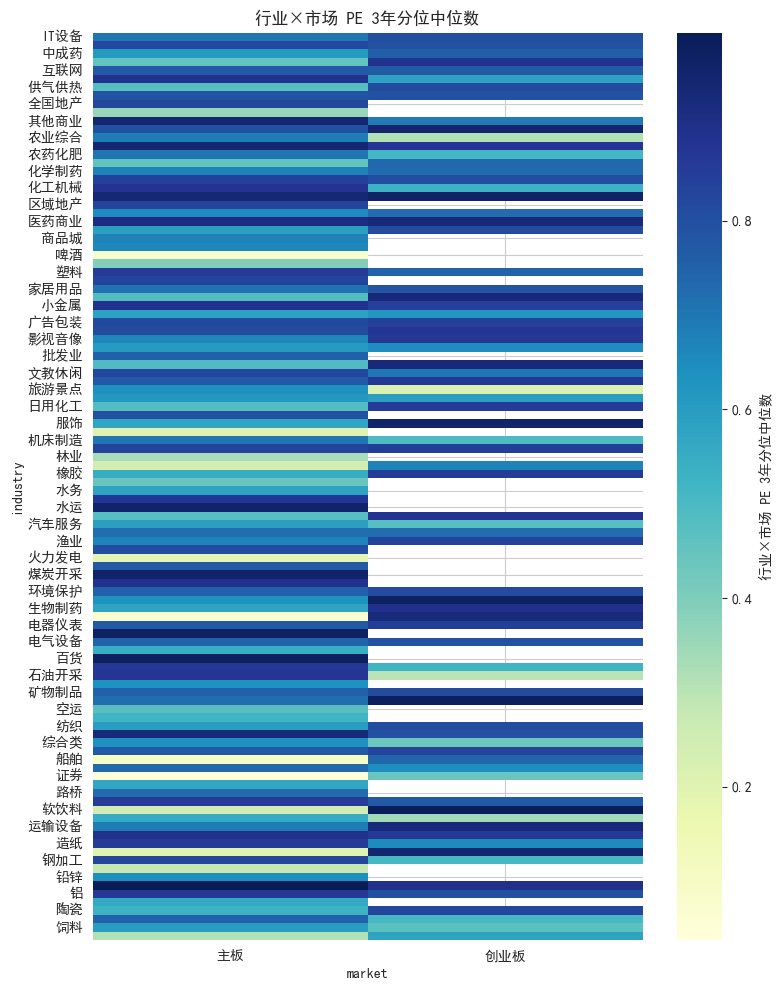

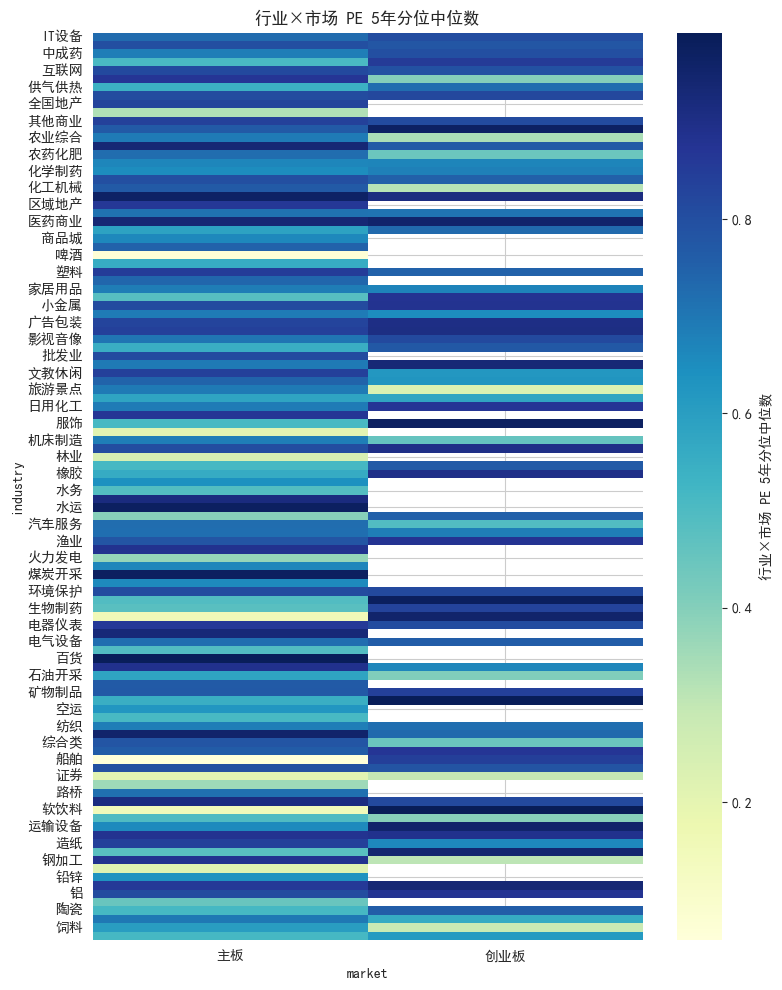

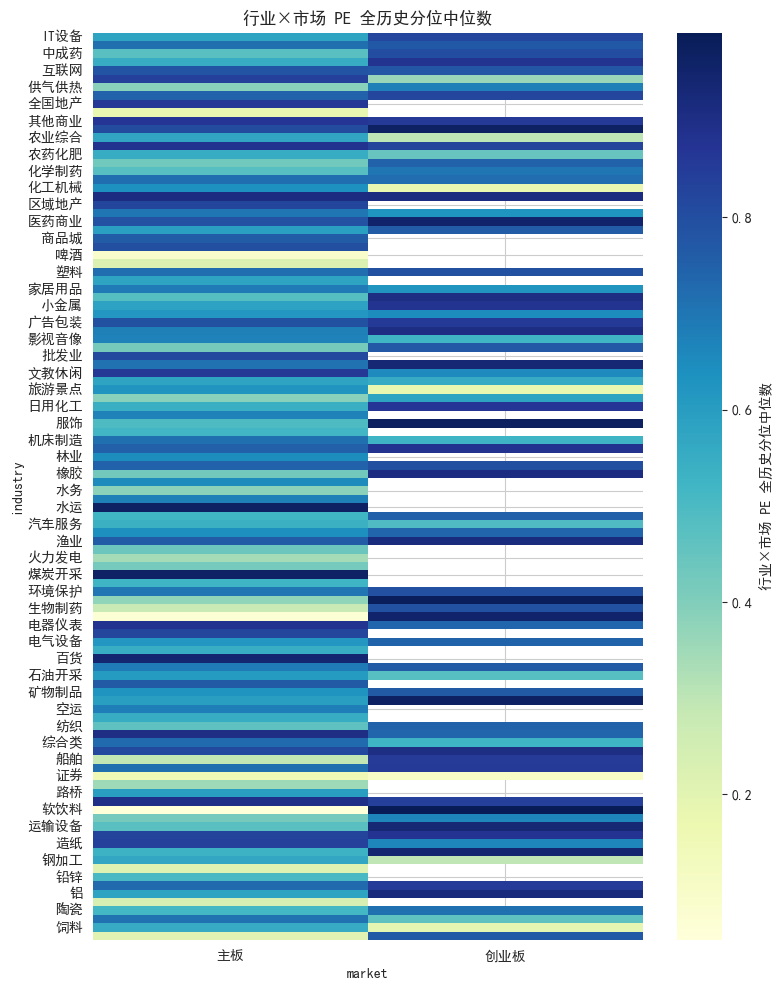

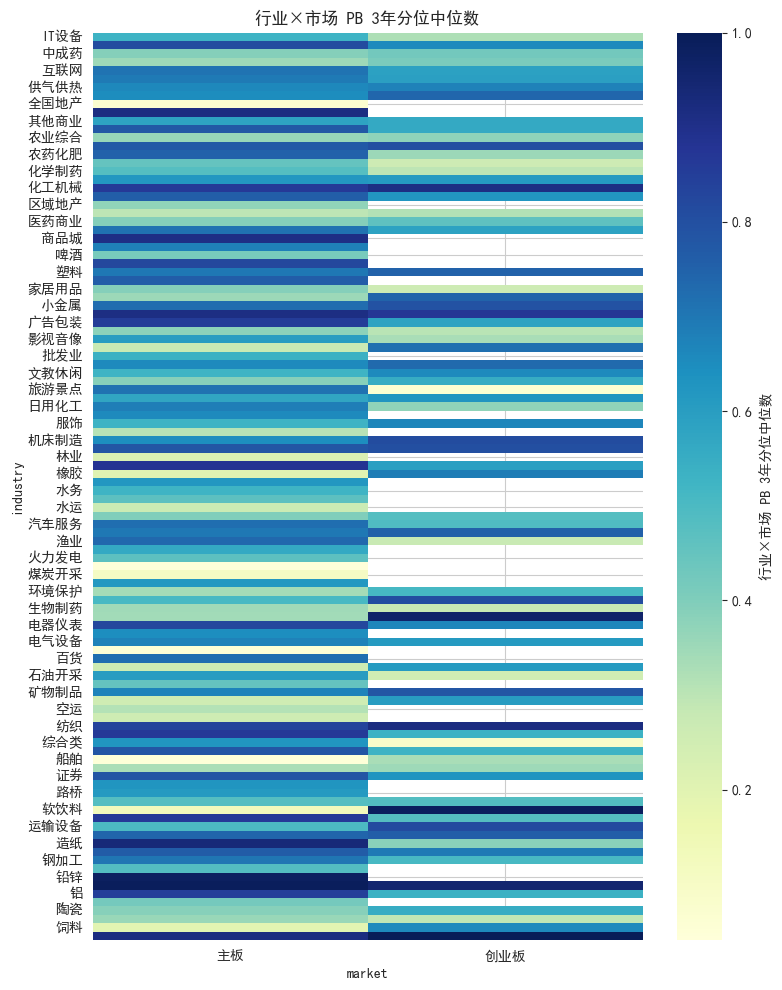

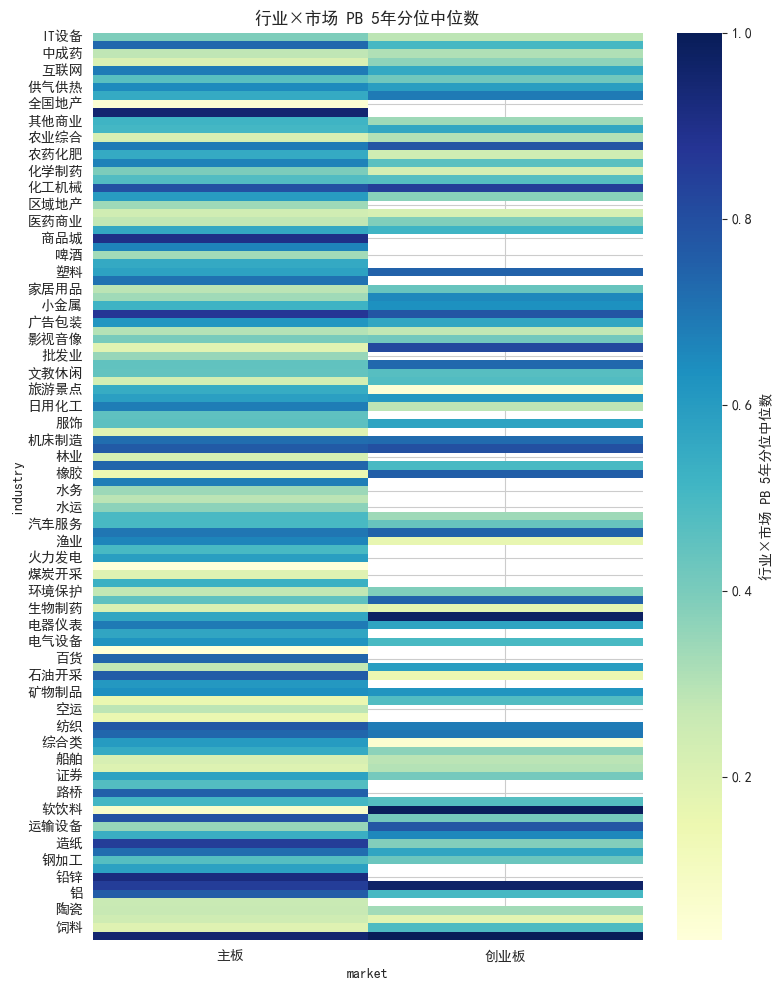

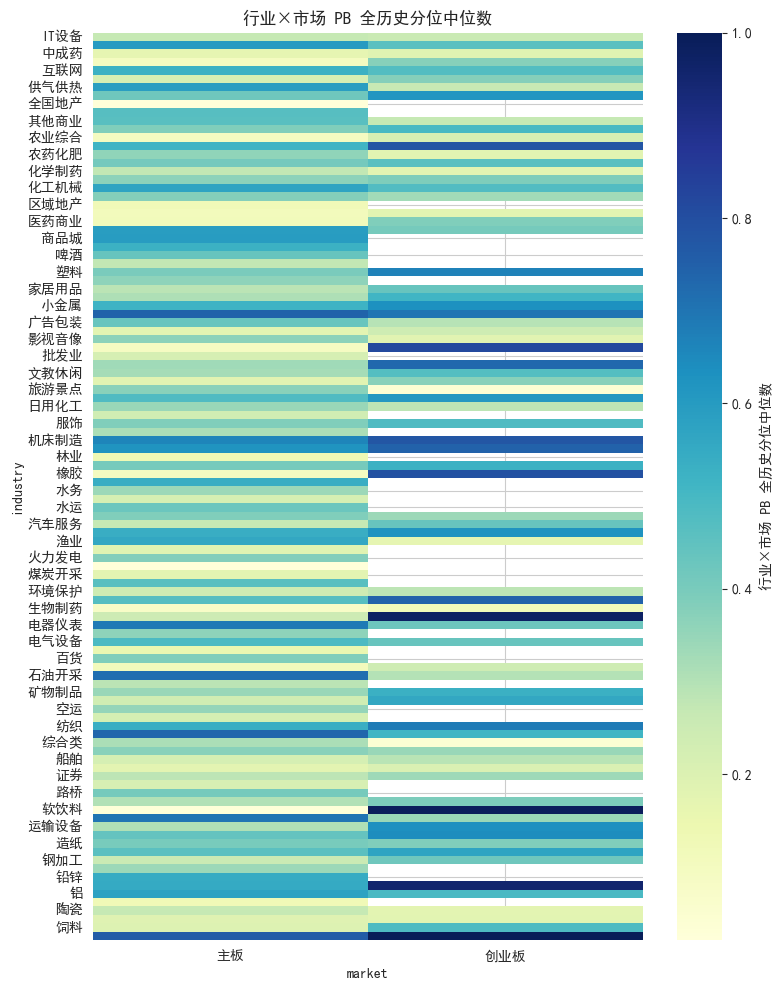

In [18]:
# 分行业当前分位热力图（PE/PB，3y/5y/full）
if 'df_hist' not in globals():
    print('df_hist 未定义，需先运行 3.5 历史分位计算单元，当前单元跳过')
elif df_hist.empty:
    print('df_hist 为空，跳过热力图')
else:
    def plot_industry_heatmap(value_col: str, title: str):
        df_ind_heat = df_hist.pivot_table(index='industry', columns='market', values=value_col, aggfunc='median')
        df_ind_heat = df_ind_heat.dropna(how='all')
        if df_ind_heat.empty:
            print(f'{title} 行业×市场分位表为空，跳过绘图')
            return
        plt.figure(figsize=(8, 10))
        sns.heatmap(df_ind_heat, cmap='YlGnBu', annot=False, cbar_kws={'label': title})
        plt.title(title)
        plt.tight_layout()
        plt.show()

    # 依次绘制 PE/PB 的 3y/5y/full 分位热力图
    targets = [
        ('pe_ttm_3y_pct', '行业×市场 PE 3年分位中位数'),
        ('pe_ttm_5y_pct', '行业×市场 PE 5年分位中位数'),
        ('pe_ttm_full_pct', '行业×市场 PE 全历史分位中位数'),
        ('pb_3y_pct', '行业×市场 PB 3年分位中位数'),
        ('pb_5y_pct', '行业×市场 PB 5年分位中位数'),
        ('pb_full_pct', '行业×市场 PB 全历史分位中位数'),
    ]
    for col, title in targets:
        if col not in df_hist:
            print(f'{col} 缺失，跳过 {title}')
            continue
        plot_industry_heatmap(col, title)

## 3.6 估值分位数与未来收益初探
- 使用当前估值分位打标签（低/中/高），计算未来 1/3/6/12 个月收益均值与分布。
- 仅示范，默认抽样部分股票以控制运行时间。

准备评估代码数: 200
合并样本行数: 564903，无价格列跳过 0，空样本跳过 0，合并缺列 0
分位分组未来收益均值:
             ret_21d   ret_63d  ret_126d  ret_252d  ret_504d  ret_1008d
val_bucket                                                             
低估          0.010230  0.023232  0.029976  0.072504  0.187975   0.256940
中性          0.008732  0.022418  0.040448  0.075346  0.113419   0.123005
高估          0.005867  0.017777  0.032246  0.052473  0.074611   0.068111

样本数:
            ret_21d  ret_63d  ret_126d  ret_252d  ret_504d  ret_1008d
val_bucket                                                           
低估           188633   187492    185687    180268    163997     129325
中性           188339   185741    181390    172064    154808     120493
高估           187931   183270    176826    166371    149498     118223

样本覆盖率（占合并行数）:
            ret_21d  ret_63d  ret_126d  ret_252d  ret_504d  ret_1008d
val_bucket                                                           
低估            0.334    0.332     0.329     0.319     0.290      0

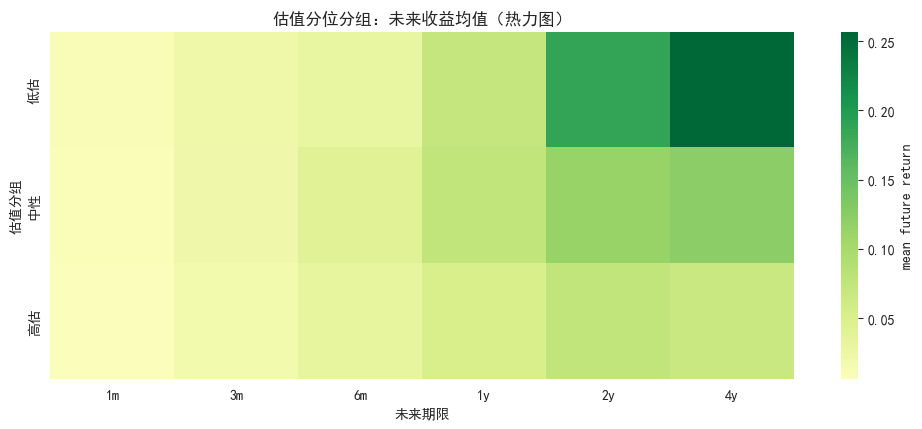

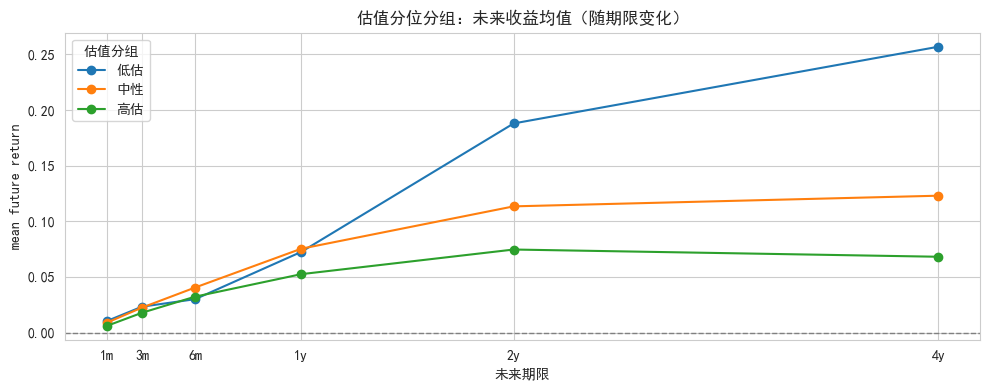

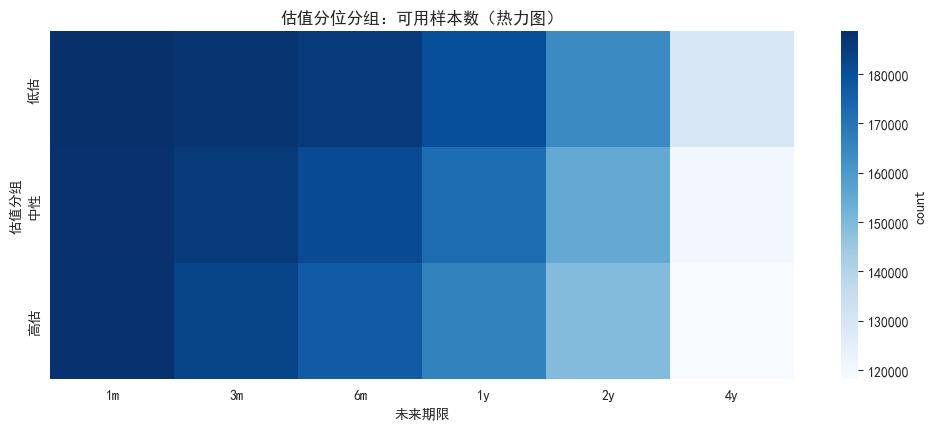

In [27]:
# 估值分位与未来收益示例（事件研究：当期估值 → 未来收益）
SAMPLE_RET = 200
HORIZONS = [21, 63, 126, 252, 504, 1008]  # 约 1m,3m,6m,1y,2y,4y
PCT_COL = 'pe_ttm_3y_pct'  # 使用 3y 估值分位分桶
ROLL_WIN = 252 * 3
MIN_ROLL = max(20, ROLL_WIN // 6)
RET_PATH = get_data_path('raw') / 'market' / 'daily'
PRICE_CANDIDATES = [
    'close','adj_close','qfq_close','hq_close',
    'close_qfq','close_hfq','adj_close_qfq','adj_close_hfq','pre_close'
 ]

# 需要先运行 3.5 生成 df_hist（用来拿样本列表、最新交易日）
if 'df_hist' not in globals():
    raise ValueError('df_hist 未定义；请先运行单元 3.5')
if df_hist.empty:
    raise ValueError('df_hist 为空，无法计算未来收益')

# 抽样有分位值的代码
codes_ret = df_hist['ts_code_norm'].dropna().unique().tolist()[:SAMPLE_RET]
print(f'准备评估代码数: {len(codes_ret)}')

def pick_price_col(df: pd.DataFrame, candidates: list[str]) -> str | None:
    for c in candidates:
        if c in df.columns:
            return c
    return None

def rolling_pct(series: pd.Series, window: int | None) -> pd.Series:
    """计算当前值在过去窗口内的分位比例，含当前值。"""
    if window is None:
        return series.expanding().apply(lambda x: (x <= x.iloc[-1]).mean(), raw=False)
    return series.rolling(window, min_periods=MIN_ROLL).apply(
        lambda x: (x <= x.iloc[-1]).mean(), raw=False
    )

ret_rows = []
skip_no_price = 0
skip_empty = 0
skip_merge_missing = 0

for code_norm in codes_ret:
    val_path = daily_valuation_dir / f"{code_norm}.parquet"
    price_path = RET_PATH / f"{code_norm}.parquet"
    if not val_path.exists() or not price_path.exists():
        continue
    df_val = load_parquet(val_path)
    df_px = load_parquet(price_path)
    price_col = pick_price_col(df_px, PRICE_CANDIDATES)
    if df_val.empty or df_px.empty or price_col is None or 'pe_ttm' not in df_val:
        if price_col is None:
            skip_no_price += 1
        skip_empty += int(df_val.empty or df_px.empty)
        continue
    df_val['trade_date'] = pd.to_datetime(df_val['trade_date'])
    df_px['trade_date'] = pd.to_datetime(df_px['trade_date'])
    df_val = df_val.sort_values('trade_date')
    df_px = df_px.sort_values('trade_date')
    # 仅保留正的 pe_ttm
    df_val = df_val[pd.to_numeric(df_val['pe_ttm'], errors='coerce') > 0]
    if df_val.empty:
        skip_empty += 1
        continue
    # 去掉估值表里可能已有的价格列，避免重名
    df_val = df_val.drop(columns=PRICE_CANDIDATES, errors='ignore')
    # 只保留价格列并避免重名
    df_px_price = df_px[['trade_date', price_col]].rename(columns={price_col: 'px_price'})
    df = df_val.merge(df_px_price, on='trade_date', how='inner')
    if 'px_price' not in df.columns:
        skip_merge_missing += 1
        continue
    df = df[df['trade_date'] <= latest_trade_date]
    df['px_price'] = pd.to_numeric(df['px_price'], errors='coerce')
    df = df.rename(columns={'px_price': 'close'})
    df = df.dropna(subset=['close'])
    if df.empty:
        skip_empty += 1
        continue
    df[PCT_COL] = rolling_pct(pd.to_numeric(df['pe_ttm'], errors='coerce'), ROLL_WIN)
    # 计算未来收益，相对当期估值日
    for h in HORIZONS:
        df[f'ret_{h}d'] = df['close'].shift(-h) / df['close'] - 1
    keep_cols = ['trade_date', PCT_COL] + [f'ret_{h}d' for h in HORIZONS]
    df_keep = df[keep_cols].dropna(subset=[PCT_COL])
    # 仅保留有未来收益的行
    df_keep = df_keep.dropna(subset=[f'ret_{h}d' for h in HORIZONS], how='all')
    if df_keep.empty:
        skip_empty += 1
        continue
    df_keep['ts_code_norm'] = code_norm
    ret_rows.append(df_keep)

if not ret_rows:
    print('无可用收益样本（可能缺少未来价格或估值窗口过长）')
    print(f'跳过原因：无价格列 {skip_no_price}，空样本 {skip_empty}，合并缺列 {skip_merge_missing}')
else:
    df_all = pd.concat(ret_rows, ignore_index=True, copy=False)
    ret_cols = [f'ret_{h}d' for h in HORIZONS]
    df_all = df_all.dropna(subset=[PCT_COL], how='any')
    total_rows = len(df_all)
    print(f'合并样本行数: {total_rows}，无价格列跳过 {skip_no_price}，空样本跳过 {skip_empty}，合并缺列 {skip_merge_missing}')
    if df_all.empty:
        print('所有样本分位为 NaN，无法分桶')
    else:
        uniq = df_all[PCT_COL].nunique()
        if uniq < 2:
            print('分位值不够分桶')
        else:
            bucket_count = min(3, uniq)
            labels = ['低估', '中性', '高估'][:bucket_count]
            df_all['val_bucket'] = pd.qcut(df_all[PCT_COL], q=bucket_count, labels=labels, duplicates='drop')
            stats_mean = df_all.groupby('val_bucket', observed=True)[ret_cols].mean()
            stats_count = df_all.groupby('val_bucket', observed=True)[ret_cols].count()
            # 覆盖率辅助输出
            cov = (stats_count / total_rows).round(3)
            print('分位分组未来收益均值:')
            print(stats_mean)
            print('\n样本数:')
            print(stats_count)
            print('\n样本覆盖率（占合并行数）:')
            print(cov.head())

            # ===== 可视化输出（追加） =====
            # 期限标签
            horizon_label = {21: '1m', 63: '3m', 126: '6m', 252: '1y', 504: '2y', 1008: '4y'}
            col_map = {f'ret_{h}d': horizon_label.get(h, f'{h}d') for h in HORIZONS}
            mean_plot = stats_mean.rename(columns=col_map)
            count_plot = stats_count.rename(columns=col_map)

            # 1) 均值收益热力图（bucket × horizon）
            plt.figure(figsize=(10, 2.6 + 0.6 * len(mean_plot)))
            sns.heatmap(mean_plot, cmap='RdYlGn', center=0, annot=False, cbar_kws={'label': 'mean future return'})
            plt.title('估值分位分组：未来收益均值（热力图）')
            plt.xlabel('未来期限')
            plt.ylabel('估值分组')
            plt.tight_layout()
            plt.show()

            # 2) 各组随期限变化的均值曲线
            x_days = np.array(HORIZONS, dtype=float)
            x_labels = [col_map[f'ret_{h}d'] for h in HORIZONS]
            plt.figure(figsize=(10, 4))
            for bucket in mean_plot.index:
                y = stats_mean.loc[bucket, ret_cols].values
                plt.plot(x_days, y, marker='o', label=str(bucket))
            plt.axhline(0, color='gray', linestyle='--', linewidth=1)
            plt.xticks(x_days, x_labels)
            plt.title('估值分位分组：未来收益均值（随期限变化）')
            plt.xlabel('未来期限')
            plt.ylabel('mean future return')
            plt.legend(title='估值分组')
            plt.tight_layout()
            plt.show()

            # 3) 样本数热力图（可选，快速判断覆盖）
            plt.figure(figsize=(10, 2.6 + 0.6 * len(count_plot)))
            sns.heatmap(count_plot, cmap='Blues', annot=False, cbar_kws={'label': 'count'})
            plt.title('估值分位分组：可用样本数（热力图）')
            plt.xlabel('未来期限')
            plt.ylabel('估值分组')
            plt.tight_layout()
            plt.show()

## 3.7 行业中性化（PE/PB）与对比图
- 目标：去掉“行业整体估值水平差异”与“行业估值波动尺度差异”的影响，让不同股票的估值更可比。
- 方法：对每个行业内部做标准化/分位数化（默认用更稳健的 log + MAD z-score）：
  - `log_x = log(x)`（降低长尾影响）
  - `x_neu = (log_x - median(log_x|industry)) / MAD(log_x|industry)`（行业内尺度归一）
  - 备选：行业内分位数（`rank(pct=True)`），彻底去绝对值尺度
- 输出：原始 vs 中性化 的分布对比图，以及 Top 行业的中性化箱线图。

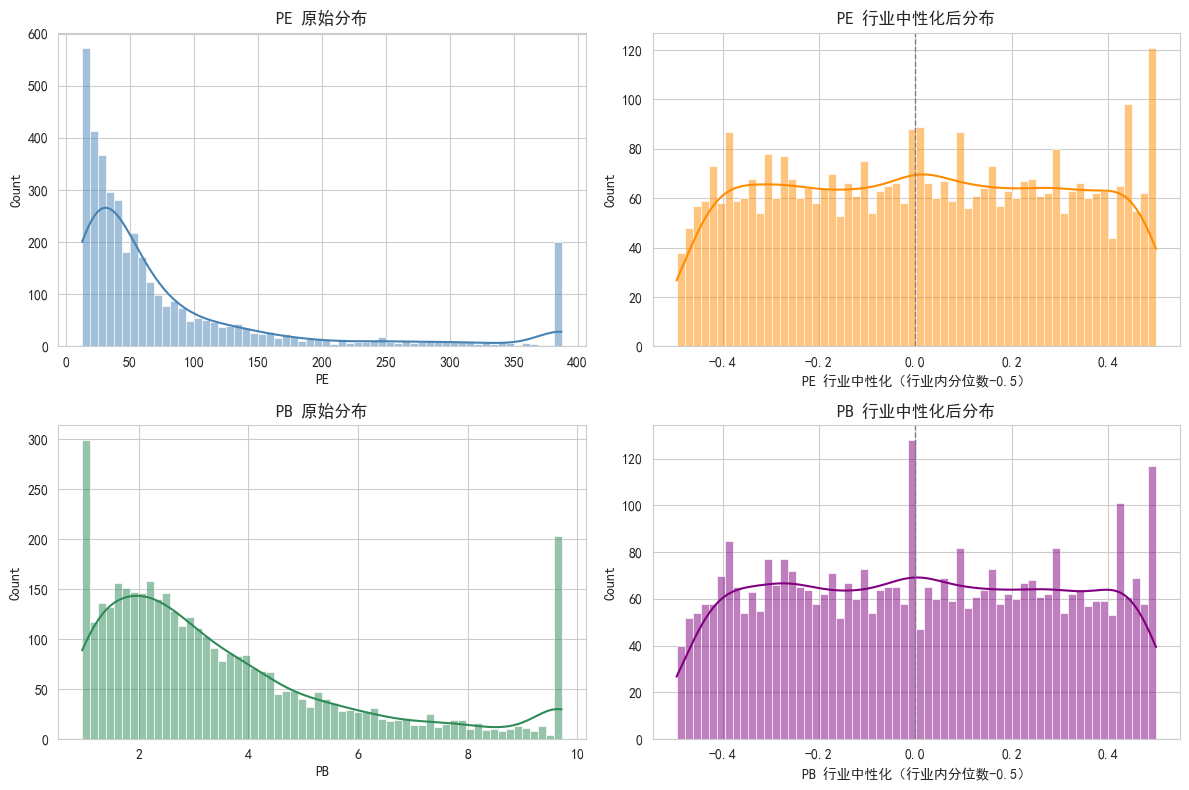

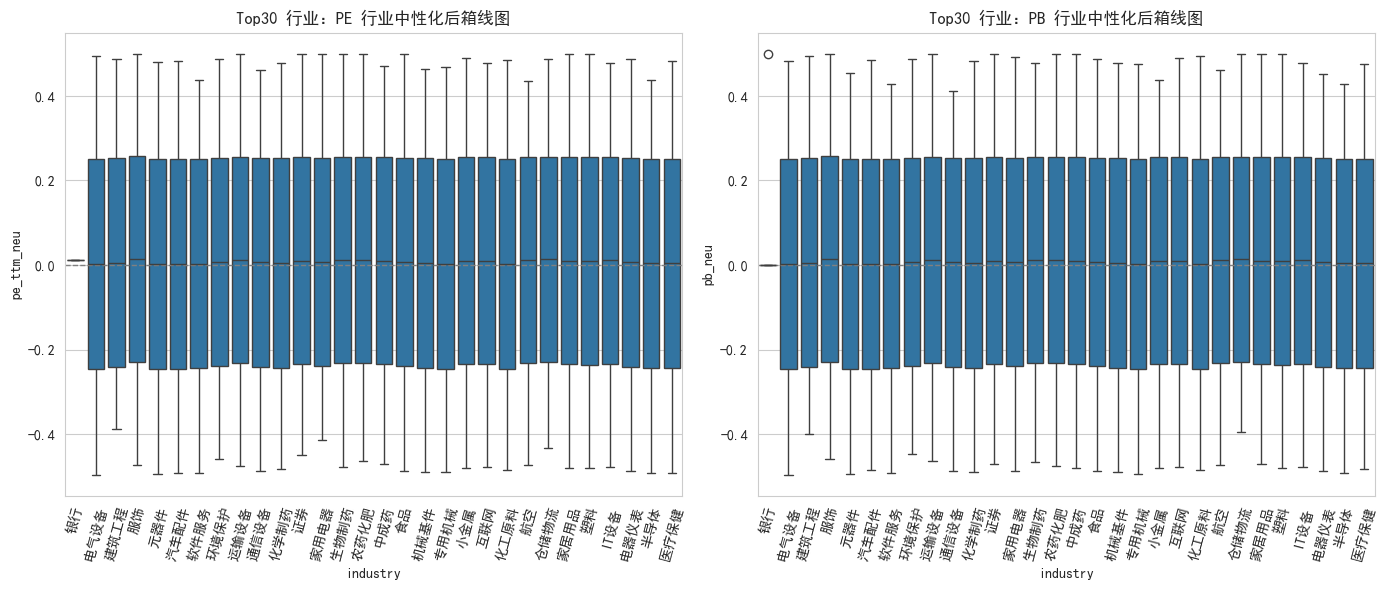

分位数中性化后的描述统计（范围应约在[-0.5,0.5]）：
        pe_ttm_neu       pb_neu
count  3922.000000  3922.000000
mean      0.014023     0.014023
std       0.287193     0.287350
min      -0.495918    -0.495918
25%      -0.235144    -0.236722
50%       0.011905     0.006226
75%       0.260744     0.261905
max       0.500000     0.500000


In [26]:
# 3.7 行业中性化（PE/PB）与对比图
NEU_MODE = 'rank_pct'  # 'zscore_log_mad' 或 'rank_pct'
TOPK_INDUSTRY = 30
EPS = 1e-12

if 'snap_clean' not in globals() or snap_clean.empty:
    raise ValueError('snap_clean 未定义或为空；请先运行 3.2')
if 'industry' not in snap_clean.columns:
    raise ValueError('snap_clean 缺少 industry 列；请检查 3.2 的 merge')

df_neu = snap_clean[['ts_code_norm', 'industry', 'market', 'pe_ttm', 'pb']].copy()
for col in ['pe_ttm', 'pb']:
    df_neu[col] = pd.to_numeric(df_neu[col], errors='coerce')
df_neu = df_neu.dropna(subset=['industry', 'pe_ttm', 'pb'])
df_neu = df_neu[(df_neu['pe_ttm'] > 0) & (df_neu['pb'] > 0)]

if df_neu.empty:
    raise ValueError('用于中性化的数据为空（pe_ttm/pb/industry 可能缺失或<=0）')

def mad_series(s: pd.Series) -> float:
    med = s.median()
    return (s - med).abs().median()

if NEU_MODE == 'zscore_log_mad':
    # log 降低长尾 + MAD 做行业内尺度归一（更稳健）
    df_neu['log_pe'] = np.log(df_neu['pe_ttm'].clip(lower=EPS))
    df_neu['log_pb'] = np.log(df_neu['pb'].clip(lower=EPS))

    pe_med = df_neu.groupby('industry')['log_pe'].transform('median')
    pb_med = df_neu.groupby('industry')['log_pb'].transform('median')
    pe_mad = df_neu.groupby('industry')['log_pe'].transform(lambda s: mad_series(s))
    pb_mad = df_neu.groupby('industry')['log_pb'].transform(lambda s: mad_series(s))

    # 防止 MAD=0（行业内几乎常数）导致除零：回退到 std，再回退到 1
    pe_std = df_neu.groupby('industry')['log_pe'].transform('std').fillna(0.0)
    pb_std = df_neu.groupby('industry')['log_pb'].transform('std').fillna(0.0)
    pe_scale = pe_mad.where(pe_mad > 0, pe_std).where(lambda x: x > 0, 1.0)
    pb_scale = pb_mad.where(pb_mad > 0, pb_std).where(lambda x: x > 0, 1.0)

    df_neu['pe_ttm_neu'] = (df_neu['log_pe'] - pe_med) / pe_scale
    df_neu['pb_neu'] = (df_neu['log_pb'] - pb_med) / pb_scale
    x_pe_raw = df_neu['log_pe']
    x_pb_raw = df_neu['log_pb']
    x_pe_raw_label = 'log(PE)'
    x_pb_raw_label = 'log(PB)'
    y_pe_neu_label = 'PE 行业中性化（log + MAD z-score）'
    y_pb_neu_label = 'PB 行业中性化（log + MAD z-score）'
elif NEU_MODE == 'rank_pct':
    # 行业内分位数（0~1），再平移到 -0.5~0.5：彻底去绝对尺度
    df_neu['pe_ttm_neu'] = df_neu.groupby('industry')['pe_ttm'].transform(lambda s: s.rank(pct=True) - 0.5)
    df_neu['pb_neu'] = df_neu.groupby('industry')['pb'].transform(lambda s: s.rank(pct=True) - 0.5)
    x_pe_raw = df_neu['pe_ttm']
    x_pb_raw = df_neu['pb']
    x_pe_raw_label = 'PE'
    x_pb_raw_label = 'PB'
    y_pe_neu_label = 'PE 行业中性化（行业内分位数-0.5）'
    y_pb_neu_label = 'PB 行业中性化（行业内分位数-0.5）'
else:
    raise ValueError("NEU_MODE 仅支持 'zscore_log_mad' 或 'rank_pct'")

# 1) 原始 vs 中性化：分布对比（全样本）
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(x_pe_raw, kde=True, ax=axes[0, 0], bins=60, color='steelblue')
axes[0, 0].set_title(f'{x_pe_raw_label} 原始分布')
axes[0, 0].set_xlabel(x_pe_raw_label)

sns.histplot(df_neu['pe_ttm_neu'], kde=True, ax=axes[0, 1], bins=60, color='darkorange')
axes[0, 1].axvline(0, color='gray', linestyle='--', linewidth=1)
axes[0, 1].set_title('PE 行业中性化后分布')
axes[0, 1].set_xlabel(y_pe_neu_label)

sns.histplot(x_pb_raw, kde=True, ax=axes[1, 0], bins=60, color='seagreen')
axes[1, 0].set_title(f'{x_pb_raw_label} 原始分布')
axes[1, 0].set_xlabel(x_pb_raw_label)

sns.histplot(df_neu['pb_neu'], kde=True, ax=axes[1, 1], bins=60, color='purple')
axes[1, 1].axvline(0, color='gray', linestyle='--', linewidth=1)
axes[1, 1].set_title('PB 行业中性化后分布')
axes[1, 1].set_xlabel(y_pb_neu_label)

plt.tight_layout()
plt.show()

# 2) Top 行业：中性化后箱线图（看行业差异是否被压平）
top_ind = df_neu['industry'].value_counts().head(TOPK_INDUSTRY).index
df_top = df_neu[df_neu['industry'].isin(top_ind)].copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.boxplot(data=df_top, x='industry', y='pe_ttm_neu', ax=axes[0])
axes[0].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[0].set_title(f'Top{TOPK_INDUSTRY} 行业：PE 行业中性化后箱线图')
axes[0].tick_params(axis='x', rotation=75)

sns.boxplot(data=df_top, x='industry', y='pb_neu', ax=axes[1])
axes[1].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[1].set_title(f'Top{TOPK_INDUSTRY} 行业：PB 行业中性化后箱线图')
axes[1].tick_params(axis='x', rotation=75)

plt.tight_layout()
plt.show()

# 简要数值校验
if NEU_MODE == 'zscore_log_mad':
    chk = df_neu.groupby('industry')[['pe_ttm_neu', 'pb_neu']].median().describe()
    print('行业中位数(中性化后)的描述统计（应接近0）：')
    print(chk)
else:
    chk = df_neu[['pe_ttm_neu', 'pb_neu']].describe()
    print('分位数中性化后的描述统计（范围应约在[-0.5,0.5]）：')
    print(chk)

## 3.8 规模中性化（PE/PB）与对比图
- 目标：去掉“规模（市值）”对估值水平的系统性影响，让估值更可比。
- 方法：在最新截面上做横截面回归，并取残差作为中性化后的估值：
  - 对 `log(PE)` 回归 `log(MV)`，`pe_size_neu = log(PE) - (a + b·log(MV))`
  - 对 `log(PB)` 回归 `log(MV)`，`pb_size_neu = log(PB) - (a + b·log(MV))`
- 输出：中性化前后 `log(PE)/log(PB)` 与 `log(MV)` 的关系散点图，以及按市值分位（decile）分组的箱线图对比。

3.8 样本量: 3922
PE 回归: log(PE) = 6.3990 + -0.1790 * log(MV) ; residual=pe_size_neu
PB 回归: log(PB) = 0.7851 + 0.0207 * log(MV) ; residual=pb_size_neu


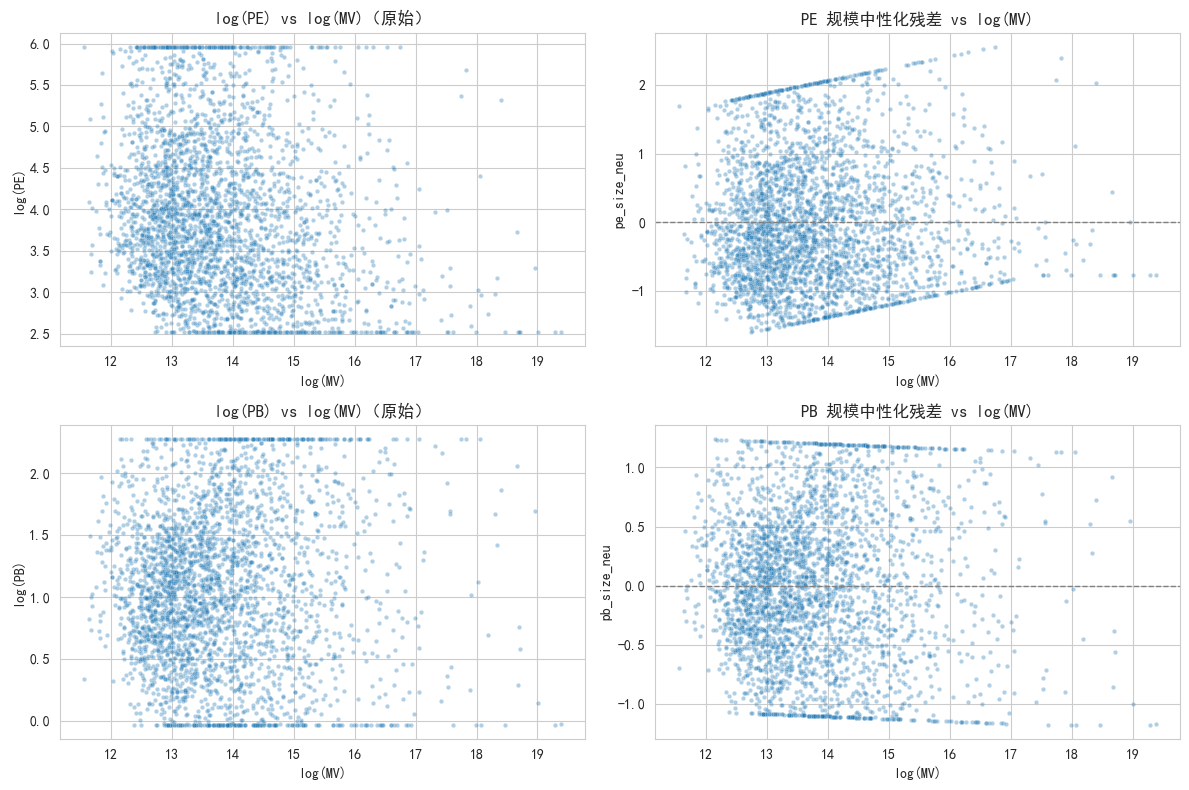

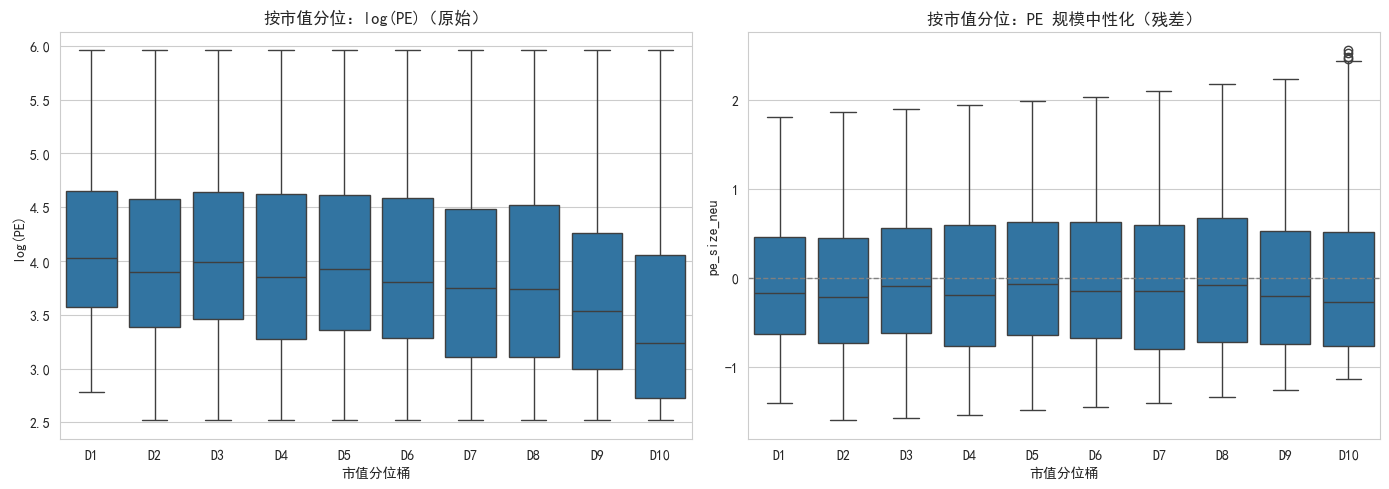

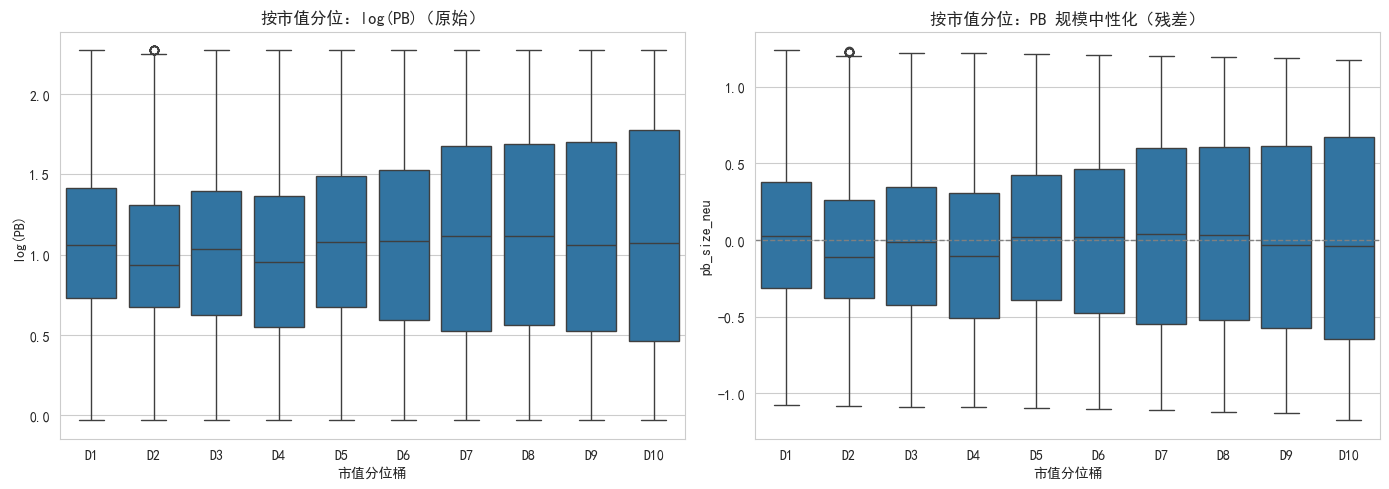

corr(log_pe, ln_mv)=-0.2109 → corr(pe_size_neu, ln_mv)=-0.0026
corr(log_pb, ln_mv)=0.0315 → corr(pb_size_neu, ln_mv)=-0.0044


In [29]:
# 3.8 规模中性化（PE/PB）：对 log(估值) 回归 log(市值)，取残差
EPS = 1e-12
SIZE_BUCKETS = 10  # 市值分位分组数（decile）
MV_CLIP_Q = (0.01, 0.99)  # 对 log(MV) 做轻度截尾，提升稳健性

if 'snap_clean' not in globals() or snap_clean.empty:
    raise ValueError('snap_clean 未定义或为空；请先运行 3.2')

need_cols = ['ts_code_norm', 'industry', 'market', 'pe_ttm', 'pb', 'total_mv']
missing = [c for c in need_cols if c not in snap_clean.columns]
if missing:
    raise ValueError(f"snap_clean 缺少列: {missing}（规模中性化需要 total_mv）")

df_38 = snap_clean[need_cols].copy()
for col in ['pe_ttm', 'pb', 'total_mv']:
    df_38[col] = pd.to_numeric(df_38[col], errors='coerce')
df_38 = df_38.dropna(subset=['pe_ttm', 'pb', 'total_mv'])
df_38 = df_38[(df_38['pe_ttm'] > 0) & (df_38['pb'] > 0) & (df_38['total_mv'] > 0)]
if df_38.empty:
    raise ValueError('3.8 过滤后样本为空（pe_ttm/pb/total_mv 可能缺失或<=0）')

# 规模变量：log(MV)
df_38['ln_mv'] = np.log(df_38['total_mv'].clip(lower=EPS))
if MV_CLIP_Q is not None:
    q_lo, q_hi = MV_CLIP_Q
    lo, hi = df_38['ln_mv'].quantile([q_lo, q_hi])
    df_38['ln_mv_clip'] = df_38['ln_mv'].clip(lo, hi)
else:
    df_38['ln_mv_clip'] = df_38['ln_mv']

# 因变量：log(PE), log(PB)
df_38['log_pe'] = np.log(df_38['pe_ttm'].clip(lower=EPS))
df_38['log_pb'] = np.log(df_38['pb'].clip(lower=EPS))

def ols_residual(y: pd.Series, x: pd.Series):
    mask = y.notna() & x.notna()
    if mask.sum() < 5:
        beta = (np.nan, np.nan)
        resid = pd.Series(index=y.index, data=np.nan, dtype=float)
        return resid, beta
    X = np.column_stack([np.ones(mask.sum()), x.loc[mask].to_numpy(dtype=float)])
    yv = y.loc[mask].to_numpy(dtype=float)
    b0, b1 = np.linalg.lstsq(X, yv, rcond=None)[0]
    y_hat = X @ np.array([b0, b1])
    resid = pd.Series(index=y.index, data=np.nan, dtype=float)
    resid.loc[mask] = yv - y_hat
    return resid, (float(b0), float(b1))

df_38['pe_size_neu'], (pe_b0, pe_b1) = ols_residual(df_38['log_pe'], df_38['ln_mv_clip'])
df_38['pb_size_neu'], (pb_b0, pb_b1) = ols_residual(df_38['log_pb'], df_38['ln_mv_clip'])

print('3.8 样本量:', len(df_38))
print(f"PE 回归: log(PE) = {pe_b0:.4f} + {pe_b1:.4f} * log(MV) ; residual=pe_size_neu")
print(f"PB 回归: log(PB) = {pb_b0:.4f} + {pb_b1:.4f} * log(MV) ; residual=pb_size_neu")

# 1) 散点：中性化前后 vs 规模
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.scatterplot(data=df_38.sample(n=min(3000, len(df_38)), random_state=42), x='ln_mv', y='log_pe', s=10, alpha=0.35, ax=axes[0, 0])
axes[0, 0].set_title('log(PE) vs log(MV)（原始）')
axes[0, 0].set_xlabel('log(MV)')
axes[0, 0].set_ylabel('log(PE)')

sns.scatterplot(data=df_38.sample(n=min(3000, len(df_38)), random_state=42), x='ln_mv', y='pe_size_neu', s=10, alpha=0.35, ax=axes[0, 1])
axes[0, 1].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[0, 1].set_title('PE 规模中性化残差 vs log(MV)')
axes[0, 1].set_xlabel('log(MV)')
axes[0, 1].set_ylabel('pe_size_neu')

sns.scatterplot(data=df_38.sample(n=min(3000, len(df_38)), random_state=42), x='ln_mv', y='log_pb', s=10, alpha=0.35, ax=axes[1, 0])
axes[1, 0].set_title('log(PB) vs log(MV)（原始）')
axes[1, 0].set_xlabel('log(MV)')
axes[1, 0].set_ylabel('log(PB)')

sns.scatterplot(data=df_38.sample(n=min(3000, len(df_38)), random_state=42), x='ln_mv', y='pb_size_neu', s=10, alpha=0.35, ax=axes[1, 1])
axes[1, 1].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[1, 1].set_title('PB 规模中性化残差 vs log(MV)')
axes[1, 1].set_xlabel('log(MV)')
axes[1, 1].set_ylabel('pb_size_neu')

plt.tight_layout()
plt.show()

# 2) 按市值分位（decile）箱线图：前后对比
try:
    df_38['mv_bucket'] = pd.qcut(df_38['ln_mv'], q=SIZE_BUCKETS, labels=[f'D{i+1}' for i in range(SIZE_BUCKETS)], duplicates='drop')
except ValueError:
    # 分位数不足时降级
    uniq = df_38['ln_mv'].nunique()
    q = int(min(SIZE_BUCKETS, max(2, uniq)))
    df_38['mv_bucket'] = pd.qcut(df_38['ln_mv'], q=q, labels=[f'D{i+1}' for i in range(q)], duplicates='drop')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(data=df_38, x='mv_bucket', y='log_pe', ax=axes[0])
axes[0].set_title('按市值分位：log(PE)（原始）')
axes[0].set_xlabel('市值分位桶')
axes[0].set_ylabel('log(PE)')

sns.boxplot(data=df_38, x='mv_bucket', y='pe_size_neu', ax=axes[1])
axes[1].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[1].set_title('按市值分位：PE 规模中性化（残差）')
axes[1].set_xlabel('市值分位桶')
axes[1].set_ylabel('pe_size_neu')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(data=df_38, x='mv_bucket', y='log_pb', ax=axes[0])
axes[0].set_title('按市值分位：log(PB)（原始）')
axes[0].set_xlabel('市值分位桶')
axes[0].set_ylabel('log(PB)')

sns.boxplot(data=df_38, x='mv_bucket', y='pb_size_neu', ax=axes[1])
axes[1].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[1].set_title('按市值分位：PB 规模中性化（残差）')
axes[1].set_xlabel('市值分位桶')
axes[1].set_ylabel('pb_size_neu')
plt.tight_layout()
plt.show()

# 简单校验：残差与规模的线性相关应显著下降（理论上 ~0）
corr_pe_raw = df_38[['log_pe', 'ln_mv']].corr().iloc[0, 1]
corr_pe_neu = df_38[['pe_size_neu', 'ln_mv']].corr().iloc[0, 1]
corr_pb_raw = df_38[['log_pb', 'ln_mv']].corr().iloc[0, 1]
corr_pb_neu = df_38[['pb_size_neu', 'ln_mv']].corr().iloc[0, 1]
print(f"corr(log_pe, ln_mv)={corr_pe_raw:.4f} → corr(pe_size_neu, ln_mv)={corr_pe_neu:.4f}")
print(f"corr(log_pb, ln_mv)={corr_pb_raw:.4f} → corr(pb_size_neu, ln_mv)={corr_pb_neu:.4f}")

## 3.9 全部中性化（行业 + 规模 + 波动 + 动量 + 换手）
- 目标：把估值信号（PE/PB）中同时剔除：
  - 行业效应（行业整体估值差异）
  - 规模效应（市值相关）
  - 风险/交易特征：波动率、动量、换手
- 方法：在最新截面做一次联合横截面回归，取残差作为“全部中性化”后的估值：
  - 因变量：`log(PE)`、`log(PB)`
  - 自变量：`log(MV)`、`log(1+turnover)`、`vol_60`、`mom_252`、行业哑变量
  - 残差：`pe_full_neu`、`pb_full_neu`
- 说明：波动/动量需要从日线价格计算（默认使用最新交易日往前的窗口）。为避免重复计算，会缓存到 `reports/cache`。

计算动量/波动: 100%|██████████| 111/111 [00:00<00:00, 157.31it/s]


3.9 可用样本量（含 mom/vol）: 3811 行业数: 110
3.9 中性化回归方法: Huber稳健回归
PE Huber: iters=17, scale=0.663966
PB Huber: iters=18, scale=0.437057

相关性（中性化前）：
         ln_mv  ln_turn  vol_60  mom_252
log_pe -0.2167   0.3920  0.3975   0.2252
log_pb  0.0352   0.3789  0.5195   0.4390

相关性（全部中性化后：残差）：
              ln_mv  ln_turn  vol_60  mom_252
pe_full_neu -0.0099  -0.0241 -0.0249  -0.0274
pb_full_neu -0.0076  -0.0093 -0.0055  -0.0181


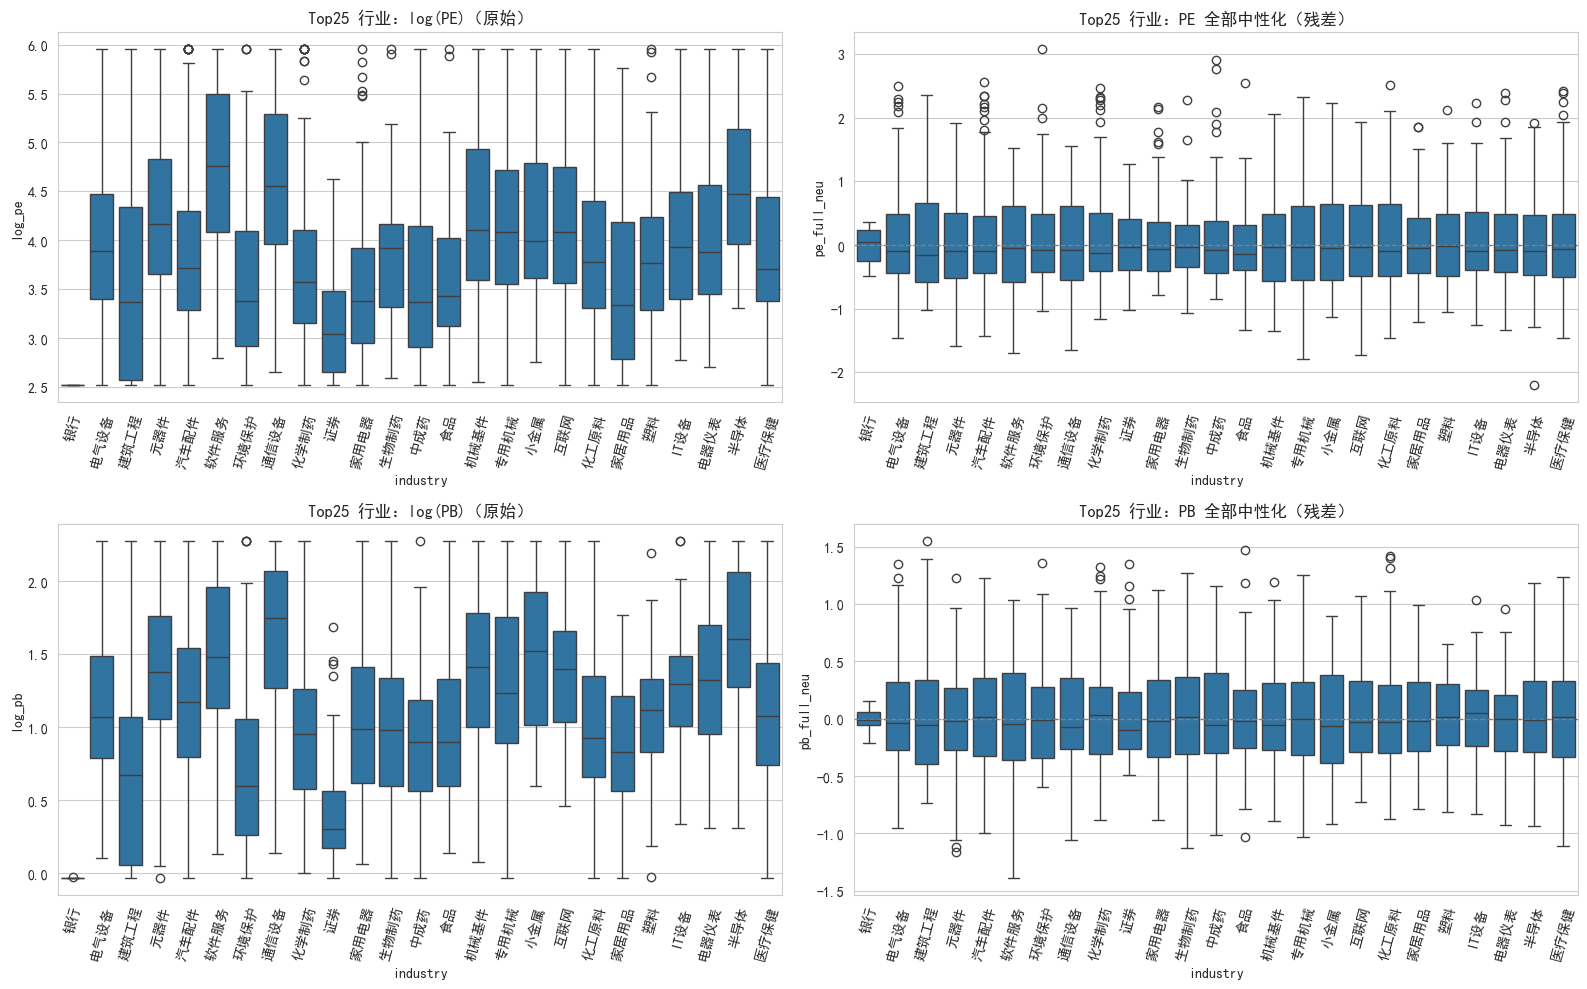

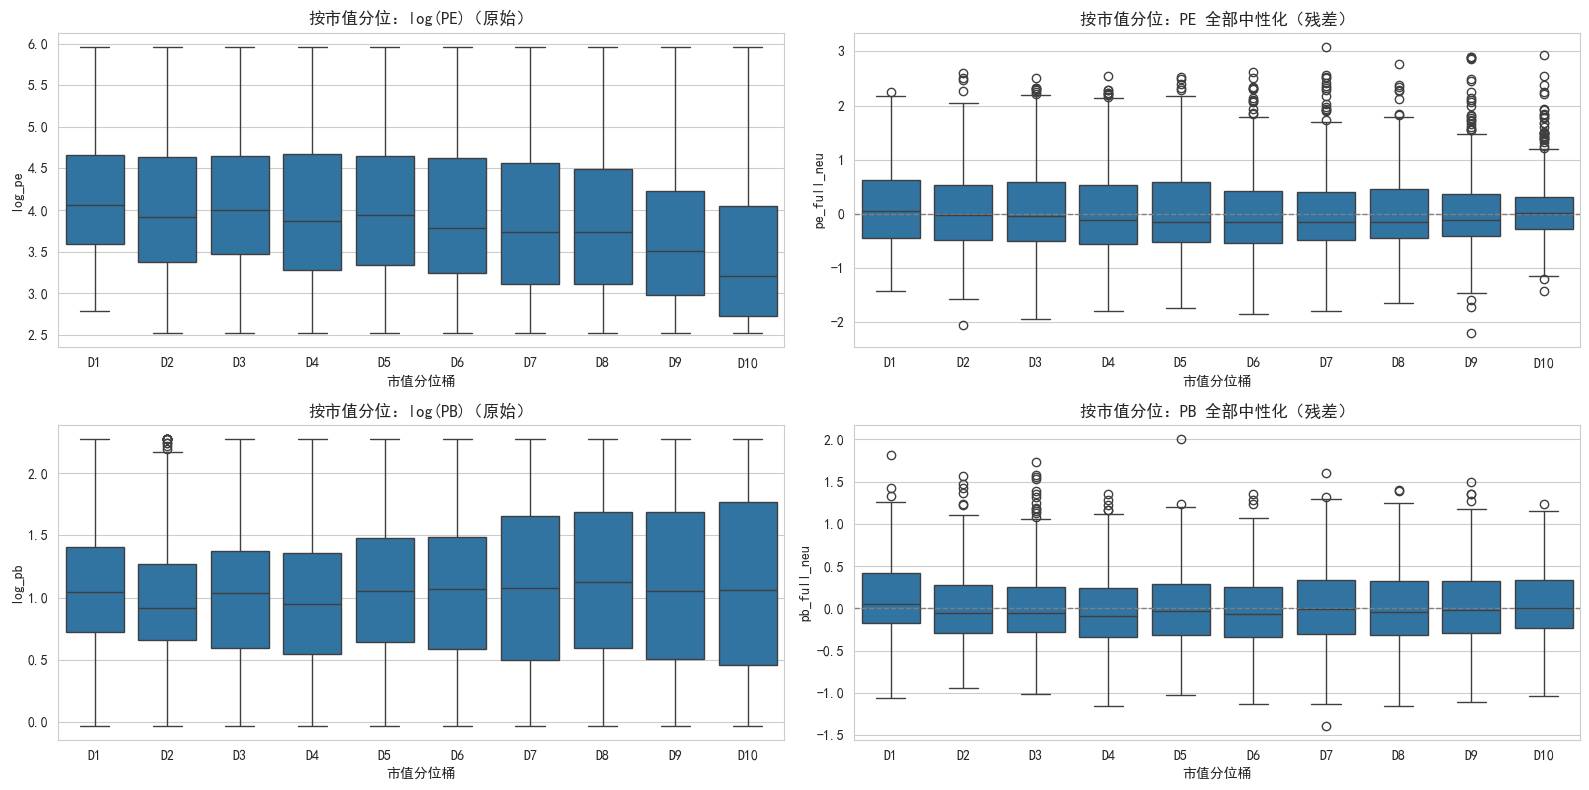

In [32]:
# 3.9 全部中性化：行业 + 规模 + 波动 + 动量 + 换手（联合回归残差）
from tqdm import tqdm

EPS = 1e-12
SAMPLE_39 = None  # 若运行太慢，可设为 1000/2000 做抽样加速；None 表示用全样本

# 是否使用更稳健的回归（Huber 迭代加权）
ROBUST_39 = True
HUBER_C = 1.345
HUBER_MAX_ITER = 30
HUBER_TOL = 1e-7

RET_PATH_39 = get_data_path('raw') / 'market' / 'daily'
PRICE_CANDIDATES_39 = globals().get('PRICE_CANDIDATES', [
    'close','adj_close','qfq_close','hq_close','close_qfq','close_hfq','adj_close_qfq','adj_close_hfq','pre_close'
 ])

# 动量/波动参数
MOM_WIN = 252   # 12个月动量（交易日）
VOL_WIN = 60    # 3个月波动（交易日）
CACHE_FEATURES_39 = cache_dir / f"features_mom{MOM_WIN}_vol{VOL_WIN}_asof_{latest_trade_date.date()}.parquet"

if 'snap_clean' not in globals() or snap_clean.empty:
    raise ValueError('snap_clean 未定义或为空；请先运行 3.2')

need_cols = ['ts_code_norm', 'industry', 'pe_ttm', 'pb', 'total_mv', 'turnover_rate']
missing = [c for c in need_cols if c not in snap_clean.columns]
if missing:
    raise ValueError(f"snap_clean 缺少列: {missing}（3.9 需要 total_mv / turnover_rate）")

df_39 = snap_clean[need_cols].copy()
for col in ['pe_ttm', 'pb', 'total_mv', 'turnover_rate']:
    df_39[col] = pd.to_numeric(df_39[col], errors='coerce')
df_39 = df_39.dropna(subset=['ts_code_norm', 'industry', 'pe_ttm', 'pb', 'total_mv', 'turnover_rate'])
df_39 = df_39[(df_39['pe_ttm'] > 0) & (df_39['pb'] > 0) & (df_39['total_mv'] > 0)]
if df_39.empty:
    raise ValueError('3.9 过滤后样本为空')

if SAMPLE_39 is not None:
    df_39 = df_39.sample(n=min(int(SAMPLE_39), len(df_39)), random_state=42).reset_index(drop=True)

# 估值与规模/换手变换
df_39['log_pe'] = np.log(df_39['pe_ttm'].clip(lower=EPS))
df_39['log_pb'] = np.log(df_39['pb'].clip(lower=EPS))
df_39['ln_mv'] = np.log(df_39['total_mv'].clip(lower=EPS))
df_39['ln_turn'] = np.log1p(df_39['turnover_rate'].clip(lower=0))

def pick_price_col(df: pd.DataFrame, candidates: list[str]) -> str | None:
    for c in candidates:
        if c in df.columns:
            return c
    return None

def compute_mom_vol_from_price(code_norm: str) -> dict | None:
    price_path = RET_PATH_39 / f"{code_norm}.parquet"
    if not price_path.exists():
        return None
    df_px = load_parquet(price_path)
    if df_px is None or df_px.empty or 'trade_date' not in df_px.columns:
        return None
    px_col = pick_price_col(df_px, PRICE_CANDIDATES_39)
    if px_col is None:
        return None
    df_px = df_px[['trade_date', px_col]].copy()
    df_px['trade_date'] = pd.to_datetime(df_px['trade_date'])
    df_px = df_px.sort_values('trade_date')
    df_px = df_px[df_px['trade_date'] <= latest_trade_date]
    df_px[px_col] = pd.to_numeric(df_px[px_col], errors='coerce')
    df_px = df_px.dropna(subset=[px_col])
    if df_px.shape[0] < max(MOM_WIN + 1, VOL_WIN + 2):
        return None
    px = df_px[px_col].to_numpy(dtype=float)
    # 波动：最近 VOL_WIN 日收益率标准差
    ret = pd.Series(px).pct_change()
    vol_60 = float(ret.tail(VOL_WIN).std(ddof=1))
    # 动量：最近 MOM_WIN 日累计收益
    mom_252 = float(px[-1] / px[-(MOM_WIN + 1)] - 1.0)
    if not np.isfinite(vol_60) or not np.isfinite(mom_252):
        return None
    return {'ts_code_norm': code_norm, 'vol_60': vol_60, 'mom_252': mom_252}

# 读取/增量更新缓存（避免每次重算）
feat = None
if CACHE_FEATURES_39.exists():
    try:
        feat = load_parquet(CACHE_FEATURES_39)
    except Exception:
        feat = None

if feat is not None and not feat.empty:
    feat = feat[['ts_code_norm', 'vol_60', 'mom_252']].drop_duplicates('ts_code_norm')
    have = set(feat['ts_code_norm'].astype(str).tolist())
else:
    feat = pd.DataFrame(columns=['ts_code_norm', 'vol_60', 'mom_252'])
    have = set()

codes_need = [c for c in df_39['ts_code_norm'].astype(str).tolist() if c not in have]
new_rows = []
for c in tqdm(codes_need, desc='计算动量/波动', total=len(codes_need)):
    out = compute_mom_vol_from_price(c)
    if out is not None:
        new_rows.append(out)

if new_rows:
    feat_new = pd.DataFrame(new_rows)
    if feat is None or feat.empty:
        feat = feat_new
    else:
        feat = pd.concat([feat, feat_new], ignore_index=True)
    feat = feat.drop_duplicates('ts_code_norm')
    # 写缓存（best-effort）
    try:
        feat.to_parquet(CACHE_FEATURES_39, index=False)
        print('已更新缓存:', CACHE_FEATURES_39)
    except Exception as e:
        print('写缓存失败（不影响继续运行）:', repr(e))

# 合并特征
df_39 = df_39.merge(feat, on='ts_code_norm', how='left')
df_39 = df_39.dropna(subset=['vol_60', 'mom_252'])
print('3.9 可用样本量（含 mom/vol）:', len(df_39), '行业数:', df_39['industry'].nunique())
if df_39.empty:
    raise ValueError('3.9 合并动量/波动后样本为空（可能缺少价格数据或窗口不足）')

def winsor_clip(s: pd.Series, q=(0.01, 0.99)) -> pd.Series:
    lo, hi = s.quantile(list(q))
    return s.clip(lo, hi)

# 对数值暴露做轻度截尾，提升稳健性
for col in ['ln_mv', 'ln_turn', 'vol_60', 'mom_252']:
    df_39[col] = winsor_clip(df_39[col])

# 构造设计矩阵：截距 + 数值特征 + 行业哑变量
X_num = df_39[['ln_mv', 'ln_turn', 'vol_60', 'mom_252']].copy()
X_ind = pd.get_dummies(df_39['industry'].astype(str), prefix='ind', drop_first=True)
X = pd.concat([X_num, X_ind], axis=1)
X.insert(0, 'const', 1.0)
X_mat = X.to_numpy(dtype=float)

def ols_residual_mat(y: pd.Series, X_mat: np.ndarray) -> tuple[pd.Series, np.ndarray]:
    yv = y.to_numpy(dtype=float)
    mask = np.isfinite(yv) & np.isfinite(X_mat).all(axis=1)
    if mask.sum() < (X_mat.shape[1] + 5):
        resid = pd.Series(index=y.index, data=np.nan, dtype=float)
        beta = np.full(X_mat.shape[1], np.nan, dtype=float)
        return resid, beta
    beta = np.linalg.lstsq(X_mat[mask], yv[mask], rcond=None)[0]
    y_hat = X_mat[mask] @ beta
    resid = pd.Series(index=y.index, data=np.nan, dtype=float)
    resid.loc[mask] = yv[mask] - y_hat
    return resid, beta

def mad_scale(x: np.ndarray) -> float:
    x = x[np.isfinite(x)]
    if x.size == 0:
        return np.nan
    med = np.median(x)
    mad = np.median(np.abs(x - med))
    return 1.4826 * mad

def huber_residual_mat(
    y: pd.Series,
    X_mat: np.ndarray,
    c: float = 1.345,
    max_iter: int = 30,
    tol: float = 1e-7,
) -> tuple[pd.Series, np.ndarray, dict]:
    yv = y.to_numpy(dtype=float)
    mask = np.isfinite(yv) & np.isfinite(X_mat).all(axis=1)
    if mask.sum() < (X_mat.shape[1] + 5):
        resid = pd.Series(index=y.index, data=np.nan, dtype=float)
        beta = np.full(X_mat.shape[1], np.nan, dtype=float)
        return resid, beta, {'iters': 0, 'scale': np.nan}

    X0 = X_mat[mask]
    y0 = yv[mask]
    beta = np.linalg.lstsq(X0, y0, rcond=None)[0]
    iters = 0
    scale = np.nan

    for it in range(max_iter):
        iters = it + 1
        r = y0 - X0 @ beta
        scale = mad_scale(r)
        if not np.isfinite(scale) or scale < EPS:
            scale = float(np.std(r, ddof=1))
        if not np.isfinite(scale) or scale < EPS:
            scale = 1.0
        u = r / scale
        w = np.ones_like(u)
        big = np.abs(u) > c
        w[big] = c / (np.abs(u[big]) + EPS)
        sw = np.sqrt(w)
        Xw = X0 * sw[:, None]
        yw = y0 * sw
        beta_new = np.linalg.lstsq(Xw, yw, rcond=None)[0]
        if np.max(np.abs(beta_new - beta)) < tol:
            beta = beta_new
            break
        beta = beta_new

    resid = pd.Series(index=y.index, data=np.nan, dtype=float)
    resid.loc[mask] = y0 - X0 @ beta
    return resid, beta, {'iters': iters, 'scale': float(scale)}

method_name = 'Huber稳健回归' if ROBUST_39 else 'OLS'
print('3.9 中性化回归方法:', method_name)

if ROBUST_39:
    df_39['pe_full_neu'], beta_pe, info_pe = huber_residual_mat(
        df_39['log_pe'], X_mat, c=HUBER_C, max_iter=HUBER_MAX_ITER, tol=HUBER_TOL
    )
    df_39['pb_full_neu'], beta_pb, info_pb = huber_residual_mat(
        df_39['log_pb'], X_mat, c=HUBER_C, max_iter=HUBER_MAX_ITER, tol=HUBER_TOL
    )
    print(f"PE Huber: iters={info_pe['iters']}, scale={info_pe['scale']:.6f}")
    print(f"PB Huber: iters={info_pb['iters']}, scale={info_pb['scale']:.6f}")
else:
    df_39['pe_full_neu'], beta_pe = ols_residual_mat(df_39['log_pe'], X_mat)
    df_39['pb_full_neu'], beta_pb = ols_residual_mat(df_39['log_pb'], X_mat)

# 校验：与各暴露的相关性应显著降低
def corr_row(ycol: str) -> pd.Series:
    cols = ['ln_mv', 'ln_turn', 'vol_60', 'mom_252']
    out = {}
    for c in cols:
        out[c] = df_39[[ycol, c]].corr().iloc[0, 1]
    return pd.Series(out, name=ycol)

corr_before = pd.concat([corr_row('log_pe'), corr_row('log_pb')], axis=1).T
corr_after = pd.concat([corr_row('pe_full_neu'), corr_row('pb_full_neu')], axis=1).T
print('\n相关性（中性化前）：')
print(corr_before.round(4))
print('\n相关性（全部中性化后：残差）：')
print(corr_after.round(4))

# 图1：Top 行业箱线图（原始 vs 全中性化残差）
TOPK_39 = 25
top_ind_39 = df_39['industry'].value_counts().head(TOPK_39).index
df_top_39 = df_39[df_39['industry'].isin(top_ind_39)].copy()

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
sns.boxplot(data=df_top_39, x='industry', y='log_pe', ax=axes[0, 0])
axes[0, 0].set_title(f'Top{TOPK_39} 行业：log(PE)（原始）')
axes[0, 0].tick_params(axis='x', rotation=75)

sns.boxplot(data=df_top_39, x='industry', y='pe_full_neu', ax=axes[0, 1])
axes[0, 1].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[0, 1].set_title(f'Top{TOPK_39} 行业：PE 全部中性化（残差）')
axes[0, 1].tick_params(axis='x', rotation=75)

sns.boxplot(data=df_top_39, x='industry', y='log_pb', ax=axes[1, 0])
axes[1, 0].set_title(f'Top{TOPK_39} 行业：log(PB)（原始）')
axes[1, 0].tick_params(axis='x', rotation=75)

sns.boxplot(data=df_top_39, x='industry', y='pb_full_neu', ax=axes[1, 1])
axes[1, 1].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[1, 1].set_title(f'Top{TOPK_39} 行业：PB 全部中性化（残差）')
axes[1, 1].tick_params(axis='x', rotation=75)

plt.tight_layout()
plt.show()

# 图2：按市值分位箱线图（原始 vs 全中性化残差）
SIZE_BUCKETS_39 = 10
try:
    df_39['mv_bucket'] = pd.qcut(df_39['ln_mv'], q=SIZE_BUCKETS_39, labels=[f'D{i+1}' for i in range(SIZE_BUCKETS_39)], duplicates='drop')
except ValueError:
    uniq = df_39['ln_mv'].nunique()
    q = int(min(SIZE_BUCKETS_39, max(2, uniq)))
    df_39['mv_bucket'] = pd.qcut(df_39['ln_mv'], q=q, labels=[f'D{i+1}' for i in range(q)], duplicates='drop')

fig, axes = plt.subplots(2, 2, figsize=(16, 8))
sns.boxplot(data=df_39, x='mv_bucket', y='log_pe', ax=axes[0, 0])
axes[0, 0].set_title('按市值分位：log(PE)（原始）')
axes[0, 0].set_xlabel('市值分位桶')

sns.boxplot(data=df_39, x='mv_bucket', y='pe_full_neu', ax=axes[0, 1])
axes[0, 1].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[0, 1].set_title('按市值分位：PE 全部中性化（残差）')
axes[0, 1].set_xlabel('市值分位桶')

sns.boxplot(data=df_39, x='mv_bucket', y='log_pb', ax=axes[1, 0])
axes[1, 0].set_title('按市值分位：log(PB)（原始）')
axes[1, 0].set_xlabel('市值分位桶')

sns.boxplot(data=df_39, x='mv_bucket', y='pb_full_neu', ax=axes[1, 1])
axes[1, 1].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[1, 1].set_title('按市值分位：PB 全部中性化（残差）')
axes[1, 1].set_xlabel('市值分位桶')

plt.tight_layout()
plt.show()

## 3.10 用“全部中性化”估值做月频 IC（未来收益相关性）
- 目标：检验中性化后的估值信号（3.9：行业+规模+波动+动量+换手）是否对未来收益有解释力。
- 频率：每月最后一个交易日（与财报月频对齐）。
- 口径：在每个月末 $t$：
  - 用当日截面做一次“全部中性化”，得到 `pe_full_neu(t)` / `pb_full_neu(t)`；
  - 计算未来收益 $r_{t\to t+h}$（按交易日步长 $h$）；
  - 计算截面 Spearman 相关 $IC_t(h)=corr_s(signal_t, r_{t\to t+h})$。
- 输出：不同期限的 IC 均值/波动/t 值汇总表 + IC 随时间序列图。

3.10 codes: 5466 start_date: None asof: 2025-12-26
读取缓存面板: g:\理财\Quant_A_share_LongTerm\reports\cache\panel_310_mom252_vol60_h21-63-126-252-504-756.parquet rows: 467706
3.10 中性化方法: Huber稳健回归


逐月中性化+IC: 100%|██████████| 1745/1745 [06:11<00:00,  4.70it/s]


3.10 月频 Spearman IC 汇总（PE 全中性化）：


,metric,n,mean,std,t
0,ic_pe_21d,178,-0.016930,0.058567,-3.856597
1,ic_pe_63d,176,-0.016480,0.069669,-3.138255
2,ic_pe_126d,173,-0.009250,0.070178,-1.733599
3,ic_pe_252d,167,-0.006826,0.061725,-1.429154
4,ic_pe_504d,154,-0.012479,0.061106,-2.534339
5,ic_pe_756d,142,-0.009591,0.060972,-1.874439



3.10 月频 Spearman IC 汇总（PB 全中性化）：


,metric,n,mean,std,t
0,ic_pb_21d,178,-0.020022,0.065620,-4.070802
1,ic_pb_63d,176,-0.035241,0.064752,-7.220235
2,ic_pb_126d,173,-0.047654,0.063677,-9.843384
3,ic_pb_252d,167,-0.067709,0.067656,-12.932901
4,ic_pb_504d,154,-0.091057,0.060843,-18.572123
5,ic_pb_756d,142,-0.102437,0.052801,-23.118471


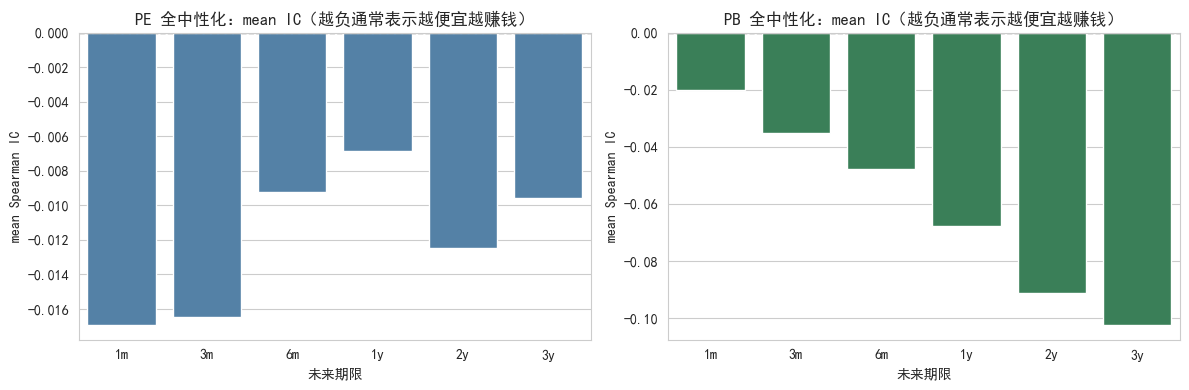

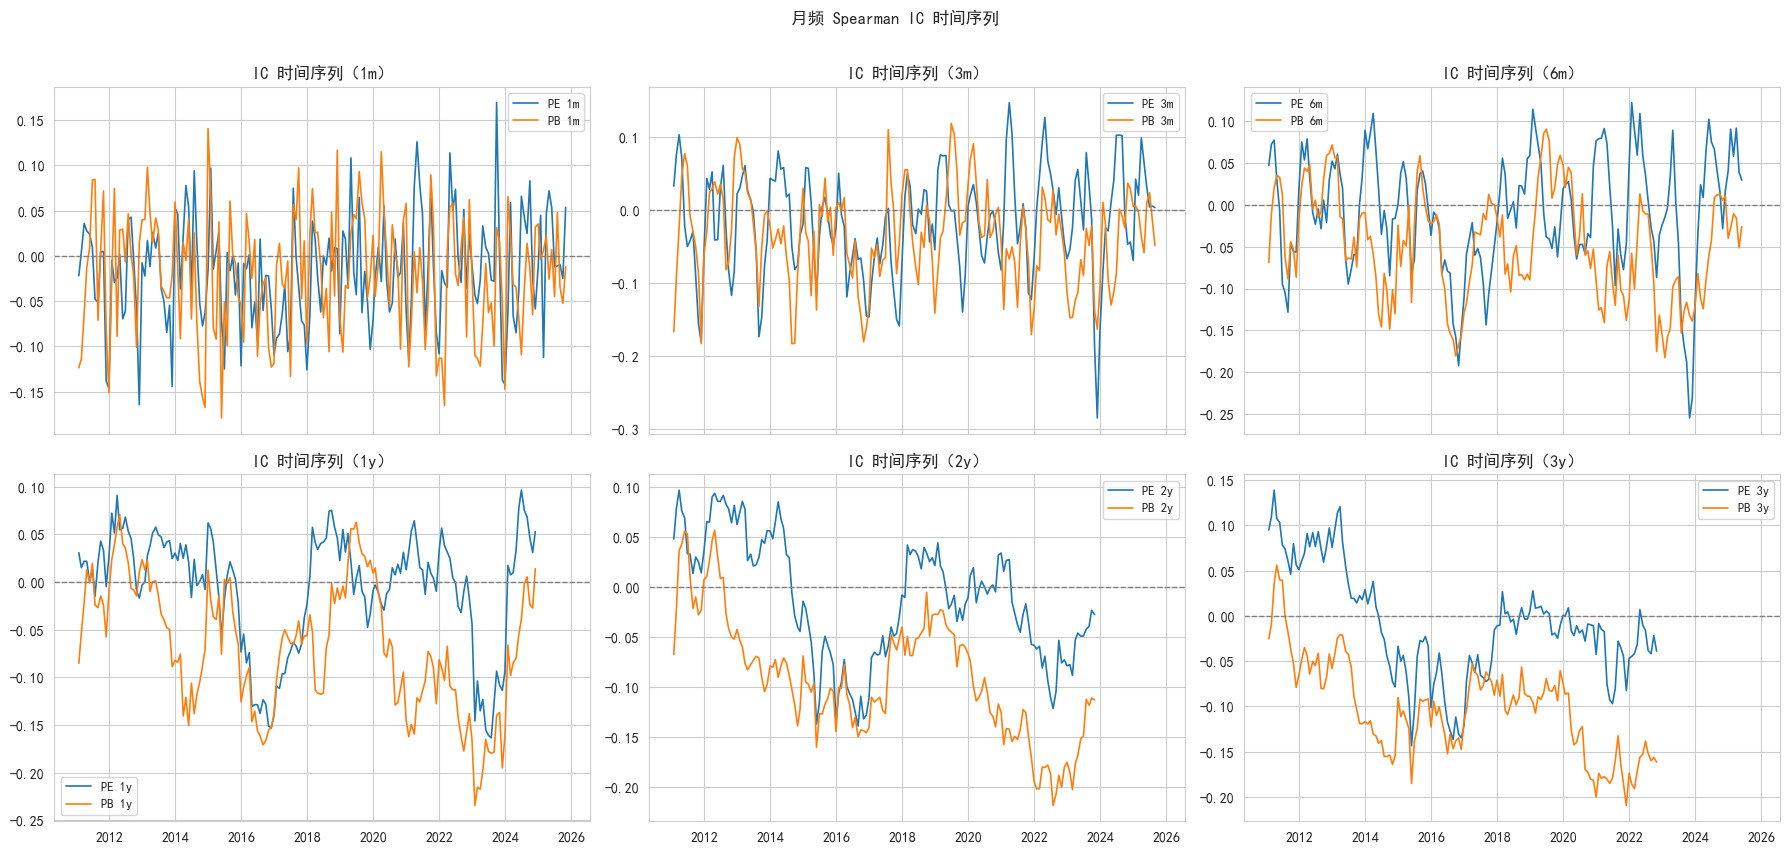

In [38]:
# 3.10 月频 IC：用 3.9 的“全部中性化”信号（行业+规模+波动+动量+换手）解释未来收益
from tqdm import tqdm

# ========= 参数 =========
EPS = 1e-12

# 月频：每月最后一个交易日
START_DATE_310 = None  # None 表示尽可能用长样本；也可设 '2015-01-01' 限制回测期
SAMPLE_CODES_310 = None  # 若运行慢，可设 1000/2000；None 用全量
MIN_CS_N = 200  # 每个截面最小样本数，不足则跳过该月

# 期限（交易日步长）；默认与 3.6 保持一致（可自行裁剪）
HORIZONS_310 = [21, 63, 126, 252, 504, 756]

# 动量/波动窗口（交易日）
MOM_WIN_310 = 252
VOL_WIN_310 = 60

# 中性化回归：稳健版（Huber）
ROBUST_310 = True
HUBER_C_310 = 1.345
HUBER_MAX_ITER_310 = 30
HUBER_TOL_310 = 1e-7

# 数据路径
VAL_DIR_310 = daily_valuation_dir
PX_DIR_310 = get_data_path('raw') / 'market' / 'daily'
PRICE_CANDIDATES_310 = globals().get('PRICE_CANDIDATES', [
    'close','adj_close','qfq_close','hq_close','close_qfq','close_hfq','adj_close_qfq','adj_close_hfq','pre_close'
 ])

# 缓存：面板数据（估值+暴露+未来收益）
cache_panel_310 = cache_dir / f"panel_310_mom{MOM_WIN_310}_vol{VOL_WIN_310}_h{'-'.join(map(str,HORIZONS_310))}.parquet"

if 'latest_trade_date' not in globals():
    raise ValueError('latest_trade_date 未定义；请先运行 3.1')
if 'stock_basic' not in globals() or stock_basic.empty:
    raise ValueError('stock_basic 未定义或为空；请先运行 3.1')

# ========= 工具函数 =========
def pick_price_col(df: pd.DataFrame, candidates: list[str]) -> str | None:
    for c in candidates:
        if c in df.columns:
            return c
    return None

def month_ends_from_dates(dates: pd.Series) -> pd.Series:
    # 输入：datetime64[ns] series（交易日） -> 每月最后一个交易日（日期）
    s = pd.to_datetime(dates).dropna().sort_values()
    if s.empty:
        return s
    g = s.groupby(s.dt.to_period('M'))
    return g.max().sort_values()

def winsor_clip(s: pd.Series, q=(0.01, 0.99)) -> pd.Series:
    lo, hi = s.quantile(list(q))
    return s.clip(lo, hi)

def mad_scale(x: np.ndarray) -> float:
    x = x[np.isfinite(x)]
    if x.size == 0:
        return np.nan
    med = np.median(x)
    mad = np.median(np.abs(x - med))
    return 1.4826 * mad

def huber_residual_mat(
    y: np.ndarray,
    X: np.ndarray,
    c: float = 1.345,
    max_iter: int = 30,
    tol: float = 1e-7,
) -> tuple[np.ndarray, np.ndarray, dict]:
    # 返回：resid（仅 mask 行有效）、beta、info
    mask = np.isfinite(y) & np.isfinite(X).all(axis=1)
    if mask.sum() < (X.shape[1] + 5):
        resid = np.full_like(y, np.nan, dtype=float)
        beta = np.full(X.shape[1], np.nan, dtype=float)
        return resid, beta, {'iters': 0, 'scale': np.nan, 'n': int(mask.sum())}

    X0 = X[mask]
    y0 = y[mask]
    beta = np.linalg.lstsq(X0, y0, rcond=None)[0]
    iters = 0
    scale = np.nan
    for it in range(max_iter):
        iters = it + 1
        r = y0 - X0 @ beta
        scale = mad_scale(r)
        if not np.isfinite(scale) or scale < EPS:
            scale = float(np.std(r, ddof=1))
        if not np.isfinite(scale) or scale < EPS:
            scale = 1.0
        u = r / scale
        w = np.ones_like(u)
        big = np.abs(u) > c
        w[big] = c / (np.abs(u[big]) + EPS)
        sw = np.sqrt(w)
        Xw = X0 * sw[:, None]
        yw = y0 * sw
        beta_new = np.linalg.lstsq(Xw, yw, rcond=None)[0]
        if np.max(np.abs(beta_new - beta)) < tol:
            beta = beta_new
            break
        beta = beta_new

    resid = np.full_like(y, np.nan, dtype=float)
    resid[mask] = y0 - X0 @ beta
    return resid, beta, {'iters': iters, 'scale': float(scale), 'n': int(mask.sum())}

def ols_residual_mat(y: np.ndarray, X: np.ndarray) -> tuple[np.ndarray, np.ndarray, dict]:
    mask = np.isfinite(y) & np.isfinite(X).all(axis=1)
    if mask.sum() < (X.shape[1] + 5):
        resid = np.full_like(y, np.nan, dtype=float)
        beta = np.full(X.shape[1], np.nan, dtype=float)
        return resid, beta, {'n': int(mask.sum())}
    beta = np.linalg.lstsq(X[mask], y[mask], rcond=None)[0]
    resid = np.full_like(y, np.nan, dtype=float)
    resid[mask] = y[mask] - X[mask] @ beta
    return resid, beta, {'n': int(mask.sum())}

def future_return_from_price(px: np.ndarray, i: int, h: int) -> float:
    j = i + h
    if i < 0 or j >= px.size:
        return np.nan
    if not np.isfinite(px[i]) or not np.isfinite(px[j]) or px[i] <= 0:
        return np.nan
    return float(px[j] / px[i] - 1.0)

def mom_from_price(px: np.ndarray, i: int, win: int) -> float:
    j = i - win
    if j < 0 or i >= px.size:
        return np.nan
    if not np.isfinite(px[i]) or not np.isfinite(px[j]) or px[j] <= 0:
        return np.nan
    return float(px[i] / px[j] - 1.0)

def vol_from_price(px: np.ndarray, i: int, win: int) -> float:
    # 使用过去 win 日（含当日）的日收益率波动
    if i < 2 or i - win + 1 < 1:
        return np.nan
    r = pd.Series(px[: i + 1]).pct_change().to_numpy(dtype=float)
    seg = r[max(1, i - win + 1) : i + 1]
    seg = seg[np.isfinite(seg)]
    if seg.size < max(10, win // 3):
        return np.nan
    return float(np.std(seg, ddof=1))

# ========= 1) 构建/读取月末面板 =========
if START_DATE_310 is None:
    start_dt_310 = None
else:
    start_dt_310 = pd.to_datetime(START_DATE_310)

codes_all = stock_basic['ts_code_norm'].dropna().astype(str).unique().tolist()
if SAMPLE_CODES_310 is not None:
    codes_all = list(pd.Series(codes_all).sample(n=min(int(SAMPLE_CODES_310), len(codes_all)), random_state=42))
print('3.10 codes:', len(codes_all), 'start_date:', start_dt_310, 'asof:', latest_trade_date.date())

panel = None
if cache_panel_310.exists():
    try:
        panel = load_parquet(cache_panel_310)
        if panel is not None and not panel.empty:
            panel['trade_date'] = pd.to_datetime(panel['trade_date'])
            print('读取缓存面板:', cache_panel_310, 'rows:', len(panel))
    except Exception as e:
        panel = None
        print('读取缓存失败，将重建:', repr(e))

if panel is None or panel.empty:
    rows = []
    max_h = int(max(HORIZONS_310)) if HORIZONS_310 else 0

    for code_norm in tqdm(codes_all, desc='构建月末面板', total=len(codes_all)):
        val_path = VAL_DIR_310 / f"{code_norm}.parquet"
        px_path = PX_DIR_310 / f"{code_norm}.parquet"
        if (not val_path.exists()) or (not px_path.exists()):
            continue

        df_val = load_parquet(val_path)
        df_px = load_parquet(px_path)
        if df_val is None or df_px is None or df_val.empty or df_px.empty:
            continue

        if 'trade_date' not in df_val.columns or 'trade_date' not in df_px.columns:
            continue
        if 'pe_ttm' not in df_val.columns or 'pb' not in df_val.columns:
            continue

        px_col = pick_price_col(df_px, PRICE_CANDIDATES_310)
        if px_col is None:
            continue

        df_val = df_val[['trade_date', 'pe_ttm', 'pb', 'total_mv', 'turnover_rate']].copy()
        df_val['trade_date'] = pd.to_datetime(df_val['trade_date'])
        df_val = df_val.sort_values('trade_date')
        df_val = df_val[df_val['trade_date'] <= latest_trade_date]
        if start_dt_310 is not None:
            df_val = df_val[df_val['trade_date'] >= start_dt_310]
        if df_val.empty:
            continue

        mends = month_ends_from_dates(df_val['trade_date'])
        if mends.empty:
            continue

        df_px = df_px[['trade_date', px_col]].copy()
        df_px['trade_date'] = pd.to_datetime(df_px['trade_date'])
        df_px = df_px.sort_values('trade_date')
        # 需要未来 max_h 天价格才能算未来收益
        df_px = df_px[df_px['trade_date'] <= latest_trade_date + pd.Timedelta(days=3650)]
        df_px[px_col] = pd.to_numeric(df_px[px_col], errors='coerce')
        df_px = df_px.dropna(subset=[px_col])
        if df_px.shape[0] < max(MOM_WIN_310 + 5, VOL_WIN_310 + 5):
            continue

        d_arr = df_px['trade_date'].to_numpy()
        p_arr = df_px[px_col].to_numpy(dtype=float)
        # 建日期->位置映射（只对月末查找，searchsorted 更快）
        for t in mends.to_list():
            # 找到 t 在价格序列中的位置（要求精确匹配交易日）
            i = int(np.searchsorted(d_arr, np.datetime64(t)))
            if i >= d_arr.size or pd.Timestamp(d_arr[i]) != pd.Timestamp(t):
                continue
            # 估值行
            cur = df_val[df_val['trade_date'] == t]
            if cur.empty:
                continue
            cur = cur.iloc[-1]
            pe = pd.to_numeric(cur.get('pe_ttm', np.nan), errors='coerce')
            pb = pd.to_numeric(cur.get('pb', np.nan), errors='coerce')
            mv = pd.to_numeric(cur.get('total_mv', np.nan), errors='coerce')
            turn = pd.to_numeric(cur.get('turnover_rate', np.nan), errors='coerce')
            if not (np.isfinite(pe) and np.isfinite(pb) and np.isfinite(mv) and np.isfinite(turn)):
                continue
            if pe <= 0 or pb <= 0 or mv <= 0:
                continue

            vol = vol_from_price(p_arr, i, VOL_WIN_310)
            mom = mom_from_price(p_arr, i, MOM_WIN_310)
            if not (np.isfinite(vol) and np.isfinite(mom)):
                continue

            # 未来收益
            fut = {f'ret_{h}d': future_return_from_price(p_arr, i, int(h)) for h in HORIZONS_310}
            if all((not np.isfinite(v)) for v in fut.values()):
                continue

            rows.append({
                'ts_code_norm': code_norm,
                'trade_date': pd.Timestamp(t),
                'pe_ttm': float(pe),
                'pb': float(pb),
                'total_mv': float(mv),
                'turnover_rate': float(turn),
                'vol_60': float(vol),
                'mom_252': float(mom),
                **fut,
            })

    panel = pd.DataFrame(rows)
    if panel.empty:
        raise ValueError('3.10 面板为空：可能样本期过长/价格不足/字段缺失')

    # 合并行业（静态映射）
    ind_map = stock_basic[['ts_code_norm', 'industry']].dropna().drop_duplicates('ts_code_norm')
    panel = panel.merge(ind_map, on='ts_code_norm', how='left')
    panel['industry'] = panel['industry'].fillna('未知')

    try:
        panel.to_parquet(cache_panel_310, index=False)
        print('写入缓存面板:', cache_panel_310, 'rows:', len(panel))
    except Exception as e:
        print('写缓存面板失败（不影响继续运行）:', repr(e))

# ========= 2) 按月末截面：全部中性化 + IC =========
panel['trade_date'] = pd.to_datetime(panel['trade_date'])
panel = panel[panel['trade_date'] <= latest_trade_date]
panel = panel.dropna(subset=['industry'])

# 变换与截尾（在整体上做轻度截尾，避免极端值冲击）
panel['log_pe'] = np.log(panel['pe_ttm'].clip(lower=EPS))
panel['log_pb'] = np.log(panel['pb'].clip(lower=EPS))
panel['ln_mv'] = np.log(panel['total_mv'].clip(lower=EPS))
panel['ln_turn'] = np.log1p(panel['turnover_rate'].clip(lower=0))
for col in ['ln_mv', 'ln_turn', 'vol_60', 'mom_252']:
    panel[col] = winsor_clip(panel[col])

method_310 = 'Huber稳健回归' if ROBUST_310 else 'OLS'
print('3.10 中性化方法:', method_310)

ic_rows = []
beta_info = []

dates_310 = panel['trade_date'].sort_values().unique()
for t in tqdm(dates_310, desc='逐月中性化+IC', total=len(dates_310)):
    df_t = panel[panel['trade_date'] == t].copy()
    if df_t.shape[0] < MIN_CS_N:
        continue

    # 设计矩阵：const + 数值暴露 + 行业哑变量
    X_num = df_t[['ln_mv', 'ln_turn', 'vol_60', 'mom_252']].to_numpy(dtype=float)
    X_ind = pd.get_dummies(df_t['industry'].astype(str), prefix='ind', drop_first=True).to_numpy(dtype=float)
    const = np.ones((df_t.shape[0], 1), dtype=float)
    X = np.concatenate([const, X_num, X_ind], axis=1)

    y_pe = df_t['log_pe'].to_numpy(dtype=float)
    y_pb = df_t['log_pb'].to_numpy(dtype=float)

    if ROBUST_310:
        resid_pe, b_pe, info_pe = huber_residual_mat(y_pe, X, c=HUBER_C_310, max_iter=HUBER_MAX_ITER_310, tol=HUBER_TOL_310)
        resid_pb, b_pb, info_pb = huber_residual_mat(y_pb, X, c=HUBER_C_310, max_iter=HUBER_MAX_ITER_310, tol=HUBER_TOL_310)
    else:
        resid_pe, b_pe, info_pe = ols_residual_mat(y_pe, X)
        resid_pb, b_pb, info_pb = ols_residual_mat(y_pb, X)

    df_t['pe_full_neu'] = resid_pe
    df_t['pb_full_neu'] = resid_pb

    # IC：Spearman（rank IC）
    out = {'trade_date': pd.Timestamp(t), 'n': int(df_t.shape[0])}
    for h in HORIZONS_310:
        rcol = f'ret_{h}d'
        if rcol not in df_t.columns:
            out[f'ic_pe_{h}d'] = np.nan
            out[f'ic_pb_{h}d'] = np.nan
            continue
        x1 = df_t['pe_full_neu']
        x2 = df_t['pb_full_neu']
        y = df_t[rcol]
        # 至少要求有效样本数
        m1 = x1.notna() & y.notna()
        m2 = x2.notna() & y.notna()
        out[f'ic_pe_{h}d'] = x1[m1].corr(y[m1], method='spearman') if m1.sum() >= MIN_CS_N else np.nan
        out[f'ic_pb_{h}d'] = x2[m2].corr(y[m2], method='spearman') if m2.sum() >= MIN_CS_N else np.nan

    ic_rows.append(out)
    beta_info.append({
        'trade_date': pd.Timestamp(t),
        'n_pe': info_pe.get('n', np.nan),
        'n_pb': info_pb.get('n', np.nan),
        'iters_pe': info_pe.get('iters', np.nan),
        'iters_pb': info_pb.get('iters', np.nan),
        'scale_pe': info_pe.get('scale', np.nan),
        'scale_pb': info_pb.get('scale', np.nan),
    })

ic_df = pd.DataFrame(ic_rows).sort_values('trade_date')
if ic_df.empty:
    raise ValueError('3.10 IC 结果为空：可能每月截面样本不足或未来收益缺失')

def summarize_ic(cols: list[str]) -> pd.DataFrame:
    rows = []
    for c in cols:
        s = pd.to_numeric(ic_df[c], errors='coerce').dropna()
        n = int(s.shape[0])
        if n < 3:
            rows.append({'metric': c, 'n': n, 'mean': np.nan, 'std': np.nan, 't': np.nan})
            continue
        mu = float(s.mean())
        sd = float(s.std(ddof=1))
        t = mu / (sd / np.sqrt(n)) if sd > 0 else np.nan
        rows.append({'metric': c, 'n': n, 'mean': mu, 'std': sd, 't': t})
    out = pd.DataFrame(rows)
    return out

cols_pe = [f'ic_pe_{h}d' for h in HORIZONS_310]
cols_pb = [f'ic_pb_{h}d' for h in HORIZONS_310]
sum_pe = summarize_ic(cols_pe)
sum_pb = summarize_ic(cols_pb)

print('\n3.10 月频 Spearman IC 汇总（PE 全中性化）：')
display(sum_pe)
print('\n3.10 月频 Spearman IC 汇总（PB 全中性化）：')
display(sum_pb)

# 图：不同期限 mean IC 条形图
def horizon_label(h: int) -> str:
    mp = {21: '1m', 63: '3m', 126: '6m', 252: '1y', 504: '2y', 756: '3y', 1008: '4y'}
    return mp.get(int(h), f'{h}d')

plot_pe = sum_pe.copy()
plot_pe['h'] = [int(x.split('_')[-1].replace('d','')) for x in plot_pe['metric']]
plot_pe['label'] = plot_pe['h'].map(horizon_label)
plot_pb = sum_pb.copy()
plot_pb['h'] = [int(x.split('_')[-1].replace('d','')) for x in plot_pb['metric']]
plot_pb['label'] = plot_pb['h'].map(horizon_label)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(data=plot_pe, x='label', y='mean', ax=axes[0], color='steelblue')
axes[0].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[0].set_title('PE 全中性化：mean IC（越负通常表示越便宜越赚钱）')
axes[0].set_xlabel('未来期限')
axes[0].set_ylabel('mean Spearman IC')

sns.barplot(data=plot_pb, x='label', y='mean', ax=axes[1], color='seagreen')
axes[1].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[1].set_title('PB 全中性化：mean IC（越负通常表示越便宜越赚钱）')
axes[1].set_xlabel('未来期限')
axes[1].set_ylabel('mean Spearman IC')
plt.tight_layout()
plt.show()

# 图：月频 IC 时间序列（1m/3m/6m/1y/2y/3y）
hs = [h for h in HORIZONS_310 if h in (21, 63, 126, 252, 504, 756)]
hs = hs if hs else (HORIZONS_310 or [])
if hs:
    n = len(hs)
    ncols = 3
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 4.2 * nrows), sharex=True, sharey=False)
    axes = np.atleast_1d(axes).ravel()

    for i, h in enumerate(hs):
        ax = axes[i]
        c1 = f'ic_pe_{int(h)}d'
        c2 = f'ic_pb_{int(h)}d'
        if c1 in ic_df.columns:
            ax.plot(ic_df['trade_date'], ic_df[c1], label=f'PE {horizon_label(int(h))}', linewidth=1.2)
        if c2 in ic_df.columns:
            ax.plot(ic_df['trade_date'], ic_df[c2], label=f'PB {horizon_label(int(h))}', linewidth=1.2)
        ax.axhline(0, color='gray', linestyle='--', linewidth=1)
        ax.set_title(f'IC 时间序列（{horizon_label(int(h))}）')
        ax.legend(fontsize=9)

    # 多余子图隐藏
    for j in range(n, len(axes)):
        axes[j].set_visible(False)

    fig.suptitle('月频 Spearman IC 时间序列', y=1.01)
    plt.tight_layout()
    plt.show()

# 产出对象：ic_df（逐月 IC 序列），sum_pe/sum_pb（汇总表）

### 时间序列上能看到的要点（1m/3m/6m/1y/2y/3y，PE/PB 残差）：

- 短期 1m/3m：IC 波动大、均值围零轴，方向不稳定，短线可参考性有限。
- 中期 6m：PB 已开始偏负，PE 仍摇摆，价值效应在 PB 上先显现。
- 长期 1y/2y/3y：PB 明显持续偏负，且 2020 之后负向更深，价值（便宜）对应更好的未来收益；PE 长期也偏负但力度远弱于 PB。
- 时段结构：2015–2018 PB IC 先走弱，2020 起负向拉大并延续，表明过去几年低 PB 残差的持有期收益更占优。
- 期限结构：期限越长，PB 负 IC 越稳、幅度越大；PE 拉长后才稍有负向但不稳。
- 波动/风险：短期 IC 高噪声，策略需要较长持有或与其他信号结合；长期 PB 虽稳，但需要关注周期性（如 2020 后大幅负向的宏观/风格背景）。
- 结论：对全中性化的估值残差，PB 是主力信号，需配长持有（≥1y）才能体现稳定的负 IC；PE 辅助作用小且噪声大。

# 3.11 总结


- 数据与处理：PE/PB 以滚动对齐、行业+市值中性化残差为主，截面去极值与标准化后进行 IC/分层/回归，时间粒度月频，多期限 1m–3y。


- 截面相关：短端 IC 噪声大、均值近零；期限拉长后 PB 残差呈稳定负 IC，PE 负向较弱且不稳。


- 分层/回测要点：低 PB 组合在中长端表现更好，排序呈反向（便宜跑赢）；PE 分层信号弱且易反转，性价比低。


- 回归/稳健性：中性化后 PB 系数随期限拉长趋向显著负向，规模控制后仍成立；PE 系数多不显著或弱负。


- 时间稳定性：2020 以后 PB 负向更稳定、更深，表明价值风格在近年占优；短期波动大，需较长持有或与其他风格（动量/质量/风险）组合。


- 可用性结论：PB 残差可作为中长端价值信号主力，需控制行业/市值并设置较长持有期；PE 单独使用价值有限，可降权或仅做辅助。


- 待补充：未做相对于大盘指数的市场中性化（去除指数 beta）。可在 3.9/3.10 的中性化回归中加入当期大盘日收益/指数超额项，或先减去指数收益后再做行业+市值中性化，以检验扣除市场暴露后的纯估值效果。